In [1]:
from src.Experiments.SensitivityAnalysis import load_data
import matplotlib.pyplot as plt
import pandas as pd
from src.SugarScape import SugarScape
from mesa import batch_run
import numpy as np
from tqdm import tqdm
import itertools
from scipy.stats import kruskal, mannwhitneyu, shapiro
from itertools import combinations, product
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Load data

In [2]:
# Function to load and process the data
def load_and_process(file_path):
    """Load CSV file and process the data."""
    data = pd.read_csv(file_path)
    
    def convert_str_to_list(list_str):
        # Strip unnecessary characters and split the string
        list_str = list_str.replace('np.float64(', '').replace(')', '').strip('[]')
        list_str = list_str.split(',')
        return [float(x.strip()) for x in list_str]

    # Apply the conversion to the relevant columns
    data['Gini'] = data['Gini'].apply(lambda x: convert_str_to_list(x) if isinstance(x, str) else x)
    data['Trader Count'] = data['Trader Count'].apply(lambda x: convert_str_to_list(x) if isinstance(x, str) else x)
    
    return data

# Load and process data
uniform_data = load_and_process('TaxEffect/results_uniform.csv')
top_heavy_data = load_and_process('TaxEffect/results_top_heavy.csv')
split_data = load_and_process('TaxEffect/results_split.csv')

# Combine data into one DataFrame
data = pd.concat([uniform_data, top_heavy_data, split_data])

# Define scenarios
scenarios = [
    {'vision_mean': 4.264199728146195, 'metabolism_mean': 6.751366691663861, 'max_age_mean': 96.55008263885976,
     'repopulate_factor': 7.485186895355582, 'cell_regeneration': 1.6743798777461052, 'Scenario': 'Worst case'},
    {'vision_mean': 2.571960593573749, 'metabolism_mean': 7.285224918276071, 'max_age_mean': 93.18476642481984,
     'repopulate_factor': 5.733334645628929, 'cell_regeneration': 2.95167014375329, 'Scenario': 'Best case'},
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 96.730439318344,
     'repopulate_factor': 12.009924734011292, 'cell_regeneration': 1.5217601098120213, 'Scenario': 'Average case'},
    {'vision_mean': 3.5, 'metabolism_mean': 6, 'max_age_mean': 85,
     'repopulate_factor': 10, 'cell_regeneration': 3, 'Scenario': 'Balanced case'},
    {'vision_mean': 1.2129357354715466, 'metabolism_mean': 3.5813456028699875, 'max_age_mean': 100,
     'repopulate_factor': 5, 'cell_regeneration': 1.5217601098120213, 'Scenario': 'Slow evolving'},
    {'vision_mean': 5.089661035686731, 'metabolism_mean': 5.488567331805825, 'max_age_mean': 70,
     'repopulate_factor': 15, 'cell_regeneration': 3.368525765836239, 'Scenario': 'Fast evolving'}
]

# Assign scenarios to data
data['Scenario'] = 'Other'
for scenario in scenarios:
    data.loc[
        (data['vision_mean'] == scenario['vision_mean']) &
        (data['metabolism_mean'] == scenario['metabolism_mean']) &
        (data['max_age_mean'] == scenario['max_age_mean']) &
        (data['repopulate_factor'] == scenario['repopulate_factor']) &
        (data['cell_regeneration'] == scenario['cell_regeneration']),
        'Scenario'] = scenario['Scenario']


# Normality Check

In [3]:
# Function to check normality using the Shapiro-Wilk test
def check_normality(data, column, scenarios):
    normality_results = {}
    for scenario in scenarios:
        scenario_name = scenario['Scenario']
        subset = data[data['Scenario'] == scenario_name]
        flattened_data = np.concatenate(subset[column].values)
        if len(flattened_data) > 5000:
            flattened_data = flattened_data[:5000]  # Shapiro-Wilk test has a limit on sample size
        stat, p_value = shapiro(flattened_data)
        normality_results[scenario_name] = p_value
        if p_value < 0.05:
            print(f"The {column} data for {scenario_name} is not normally distributed (p-value = {p_value}).")
        else:
            print(f"The {column} data for {scenario_name} is normally distributed (p-value = {p_value}).")
    return normality_results

# Check normality for Gini and Trader Count
gini_normality = check_normality(data, 'Gini', scenarios)
trader_count_normality = check_normality(data, 'Trader Count', scenarios)


The Gini data for Worst case is not normally distributed (p-value = 6.671459725727358e-19).
The Gini data for Best case is not normally distributed (p-value = 1.3270110287691765e-28).
The Gini data for Average case is not normally distributed (p-value = 7.762806304581725e-46).
The Gini data for Balanced case is not normally distributed (p-value = 3.99288517495545e-31).
The Gini data for Slow evolving is not normally distributed (p-value = 1.7340004124793394e-48).
The Gini data for Fast evolving is not normally distributed (p-value = 1.2190986966910268e-30).
The Trader Count data for Worst case is not normally distributed (p-value = 1.2203799968270456e-43).
The Trader Count data for Best case is not normally distributed (p-value = 6.94442191704098e-50).
The Trader Count data for Average case is not normally distributed (p-value = 6.392167752437012e-63).
The Trader Count data for Balanced case is not normally distributed (p-value = 4.390374155549939e-56).
The Trader Count data for Slow e

# Kruskal Test

In [4]:
# Function to perform Kruskal-Wallis test
def kruskal_test(data, column, scenarios):
    results = {}
    for scenario in scenarios:
        scenario_name = scenario['Scenario']
        subset = data[data['Scenario'] == scenario_name]
        values = [np.mean(x) for x in subset[column].values]
        groups = subset[['tax_scheme', 'distributer_scheme', 'tax_rate']].apply(tuple, axis=1).values
        
        # Perform Kruskal-Wallis test
        groups_unique = np.unique(groups)
        data_grouped = [np.array([values[i] for i in range(len(values)) if groups[i] == group]) for group in groups_unique]
        
        stat, p_value = kruskal(*data_grouped)
        results[scenario_name] = (stat, p_value)
        
    return results

# Perform Kruskal-Wallis tests
kruskal_results_gini = {}
kruskal_results_trader_count = {}

map_schemes = ['uniform', 'top_heavy', 'split']

for map_scheme in map_schemes:
    map_data = data[data['map_scheme'] == map_scheme]
    kruskal_results_gini[map_scheme] = kruskal_test(map_data, 'Gini', scenarios)
    kruskal_results_trader_count[map_scheme] = kruskal_test(map_data, 'Trader Count', scenarios)

# Function to print Kruskal-Wallis test results
def print_kruskal_results(results, metric):
    print(f"\nKruskal-Wallis Test Results for {metric}:")
    print("Map Scheme | Scenario       | H-statistic | p-value")
    print("---------------------------------------------------")
    for map_scheme, scenario_dict in results.items():
        for scenario_name, result in scenario_dict.items():
            h_stat, p_value = result
            if h_stat is None:
                print(f"{map_scheme:>10} | {scenario_name:>13} | {'N/A':>11} | {p_value:>8.2e}")
            else:
                print(f"{map_scheme:>10} | {scenario_name:>13} | {h_stat:>11.3f} | {p_value:>8.2e}")

# Print Kruskal-Wallis test results
print_kruskal_results(kruskal_results_gini, 'Gini')
print_kruskal_results(kruskal_results_trader_count, 'Trader Count')



Kruskal-Wallis Test Results for Gini:
Map Scheme | Scenario       | H-statistic | p-value
---------------------------------------------------
   uniform |    Worst case |     124.143 | 9.68e-20
   uniform |     Best case |     114.193 | 8.57e-18
   uniform |  Average case |     138.959 | 1.14e-22
   uniform | Balanced case |     129.860 | 7.24e-21
   uniform | Slow evolving |     139.837 | 7.64e-23
   uniform | Fast evolving |     136.189 | 4.05e-22
 top_heavy |    Worst case |     115.869 | 4.04e-18
 top_heavy |     Best case |     103.379 | 1.06e-15
 top_heavy |  Average case |     136.367 | 3.73e-22
 top_heavy | Balanced case |     119.657 | 7.34e-19
 top_heavy | Slow evolving |     136.265 | 3.91e-22
 top_heavy | Fast evolving |     123.933 | 1.07e-19
     split |    Worst case |      93.904 | 6.91e-14
     split |     Best case |      90.909 | 2.56e-13
     split |  Average case |     134.621 | 8.29e-22
     split | Balanced case |     119.724 | 7.13e-19
     split | Slow evolvin

# PostHoc Test

In [5]:
# Function to perform one-sided post-hoc pairwise comparisons using Mann-Whitney U test
def posthoc_comparisons(data, column, scenarios, alternative='two-sided'):
    posthoc_results = {}
    for scenario in scenarios:
        scenario_name = scenario['Scenario']
        subset = data[data['Scenario'] == scenario_name]
        values = [np.mean(x) for x in subset[column].values]
        groups = subset[['tax_scheme', 'distributer_scheme', 'tax_rate']].apply(tuple, axis=1).values
        
        # Perform Mann-Whitney U test for pairwise comparisons
        unique_groups = np.unique(groups)
        group_pairs = list(product(unique_groups, repeat=2))
        p_values = {}
        
        for pair in group_pairs:
            if pair[0] == pair[1]:
                continue
            group1 = [values[i] for i in range(len(values)) if groups[i] == pair[0]]
            group2 = [values[i] for i in range(len(values)) if groups[i] == pair[1]]
            stat, p_value = mannwhitneyu(group1, group2, alternative=alternative)
            p_values[pair] = p_value
        
        posthoc_results[scenario_name] = p_values
    
    return posthoc_results

# Function to rank combinations
def rank_combinations(data, map_scheme, scenario_name, metric):
    filtered_data = data[(data['map_scheme'] == map_scheme) & (data['Scenario'] == scenario_name)]
    agg_data = filtered_data.groupby(['tax_scheme', 'distributer_scheme', 'tax_rate']).agg({
        f'{metric}_mean': 'mean'
    }).reset_index()
    agg_data['Rank'] = agg_data[f'{metric}_mean'].rank(method='min', ascending=(metric == 'Gini'))
    return agg_data

# Function to plot heatmaps for post-hoc comparisons
def plot_posthoc_heatmap(posthoc_results, map_scheme, scenario_name, metric):
    if not posthoc_results or scenario_name not in posthoc_results:
        print(f"No significant differences found for {metric} in {scenario_name} for {map_scheme} map")
        return

    posthoc_result = posthoc_results[scenario_name]
    unique_groups = list(set([pair[0] for pair in posthoc_result.keys()] + [pair[1] for pair in posthoc_result.keys()]))
    
    # Create a MultiIndex for handling tuples as index and columns
    multi_index = pd.MultiIndex.from_tuples(unique_groups, names=["tax_scheme", "distributer_scheme", "tax_rate"])
    
    # Initialize DataFrame for heatmap data with NaNs
    heatmap_data = pd.DataFrame(index=multi_index, columns=multi_index, dtype=float)
    
    # Fill DataFrame with p-values
    for pair, p_value in posthoc_result.items():
        heatmap_data.loc[pair[0], pair[1]] = p_value
        heatmap_data.loc[pair[1], pair[0]] = p_value

    # Fill diagonal with zeros as comparisons of the same group should be zero
    for group in unique_groups:
        heatmap_data.loc[group, group] = 0
    
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(heatmap_data, cmap='plasma', cbar=True, center=0.05, linewidths=0.5, linecolor='black')
    plt.title(f'Post-hoc Comparisons for {metric} - {scenario_name} ({map_scheme} Map)')
    plt.xlabel('Tax System Combinations')
    plt.ylabel('Tax System Combinations')
    
    # Add a legend for significance levels
    cbar = ax.collections[0].colorbar
    cbar.set_label('p-value')
    
    # Add a red dotted line at the significance threshold
    cbar.ax.axhline(y=0.05, color='red', linestyle='--', linewidth=2)
    cbar.ax.text(1.2, 0.05, 'Significance Threshold (0.05)', color='red', ha='center', va='center', rotation=90)
    
    plt.show()

# Function to convert list columns to mean values
def convert_list_to_mean(df, column):
    return df[column].apply(lambda x: np.mean(x) if isinstance(x, list) else x)

data['Gini_mean'] = convert_list_to_mean(data, 'Gini')
data['Trader Count_mean'] = convert_list_to_mean(data, 'Trader Count')


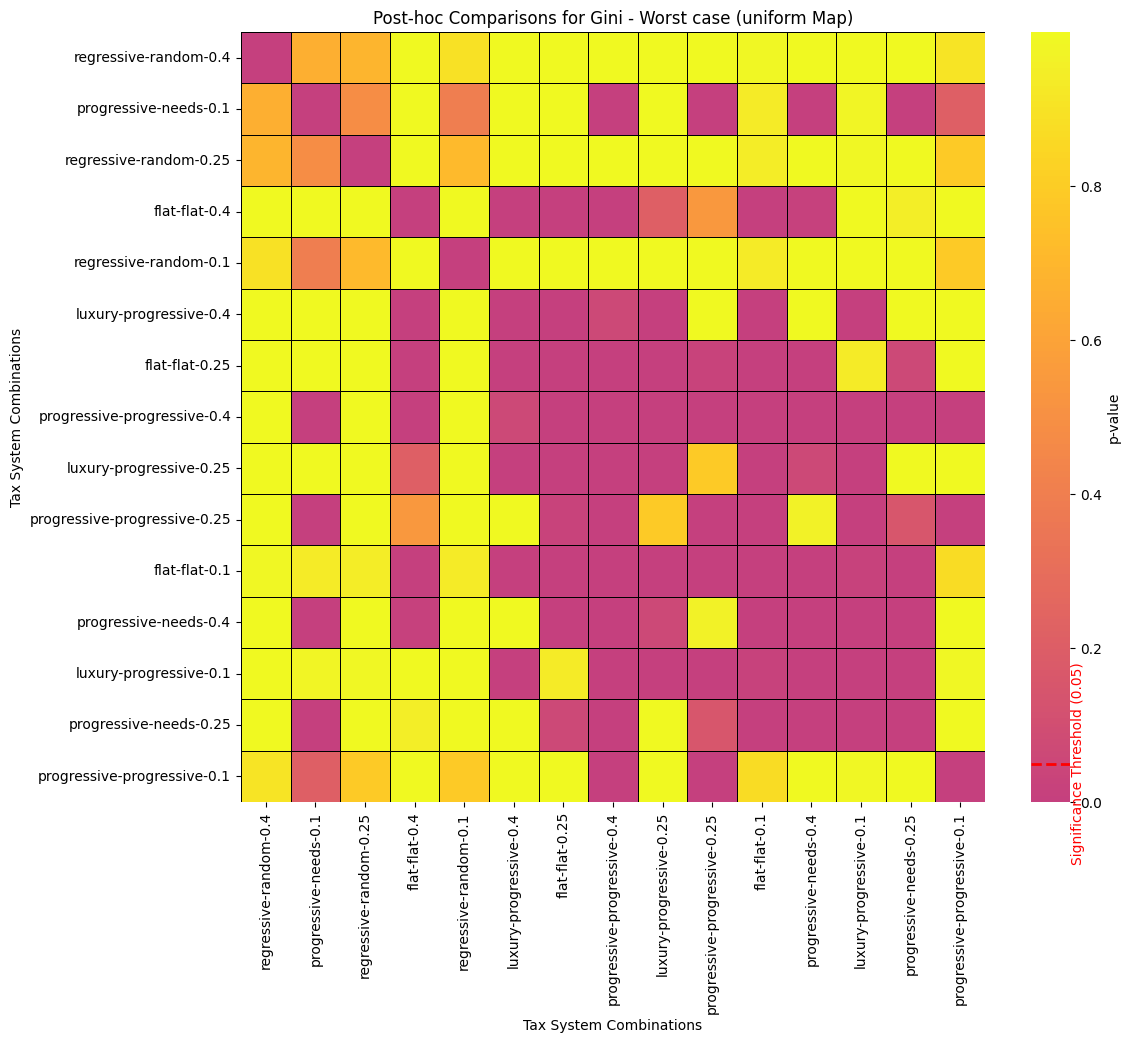

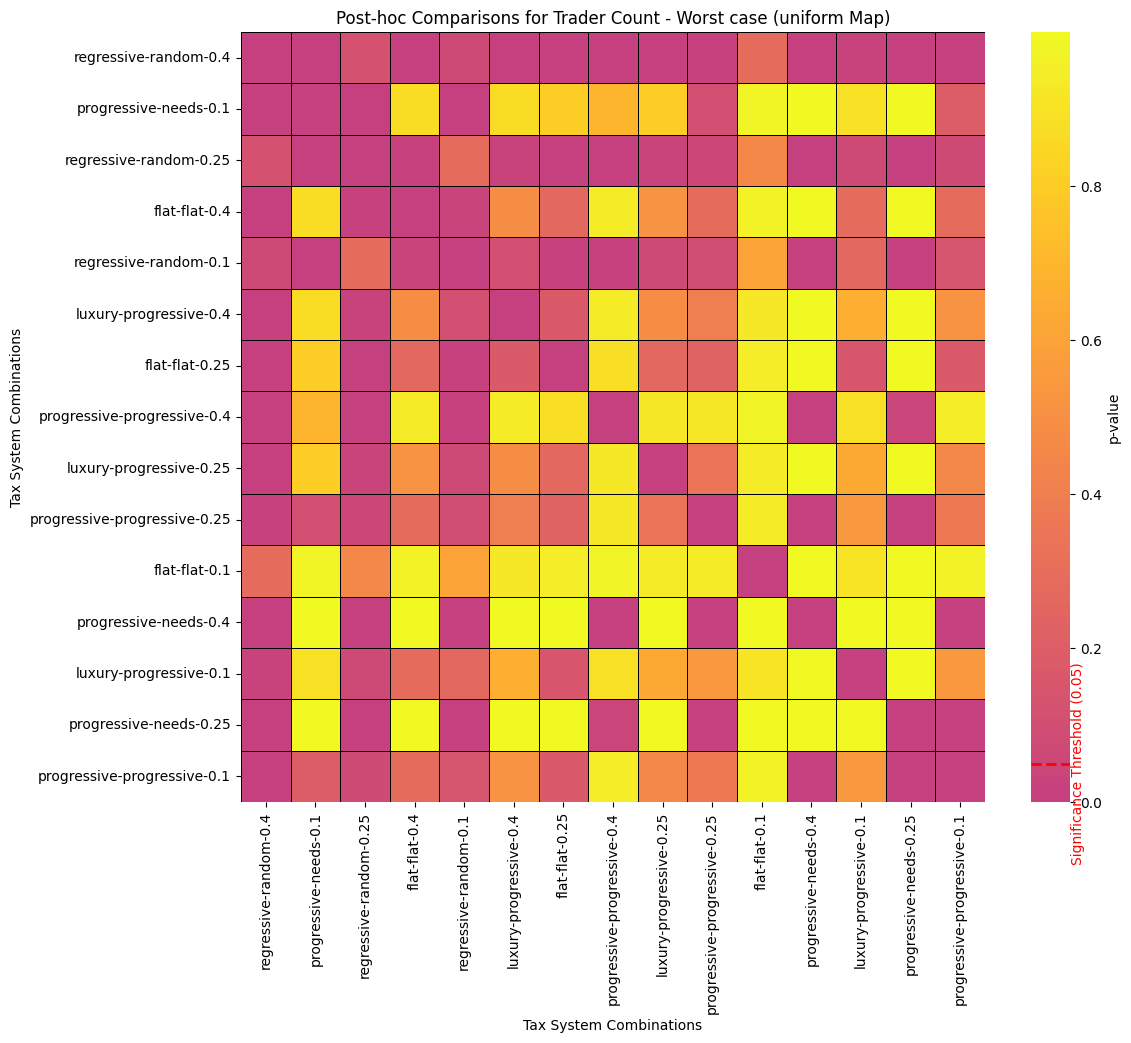

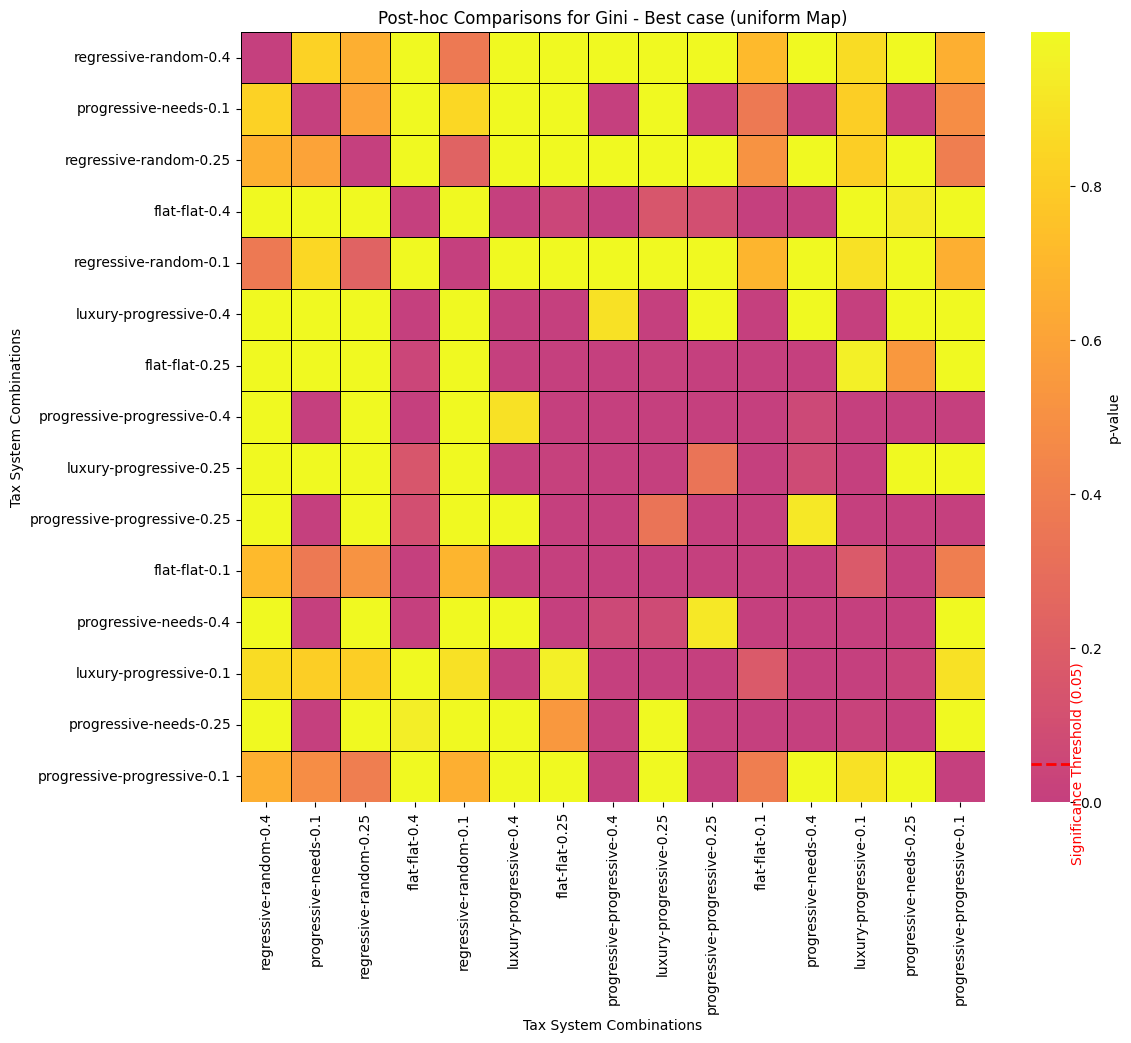

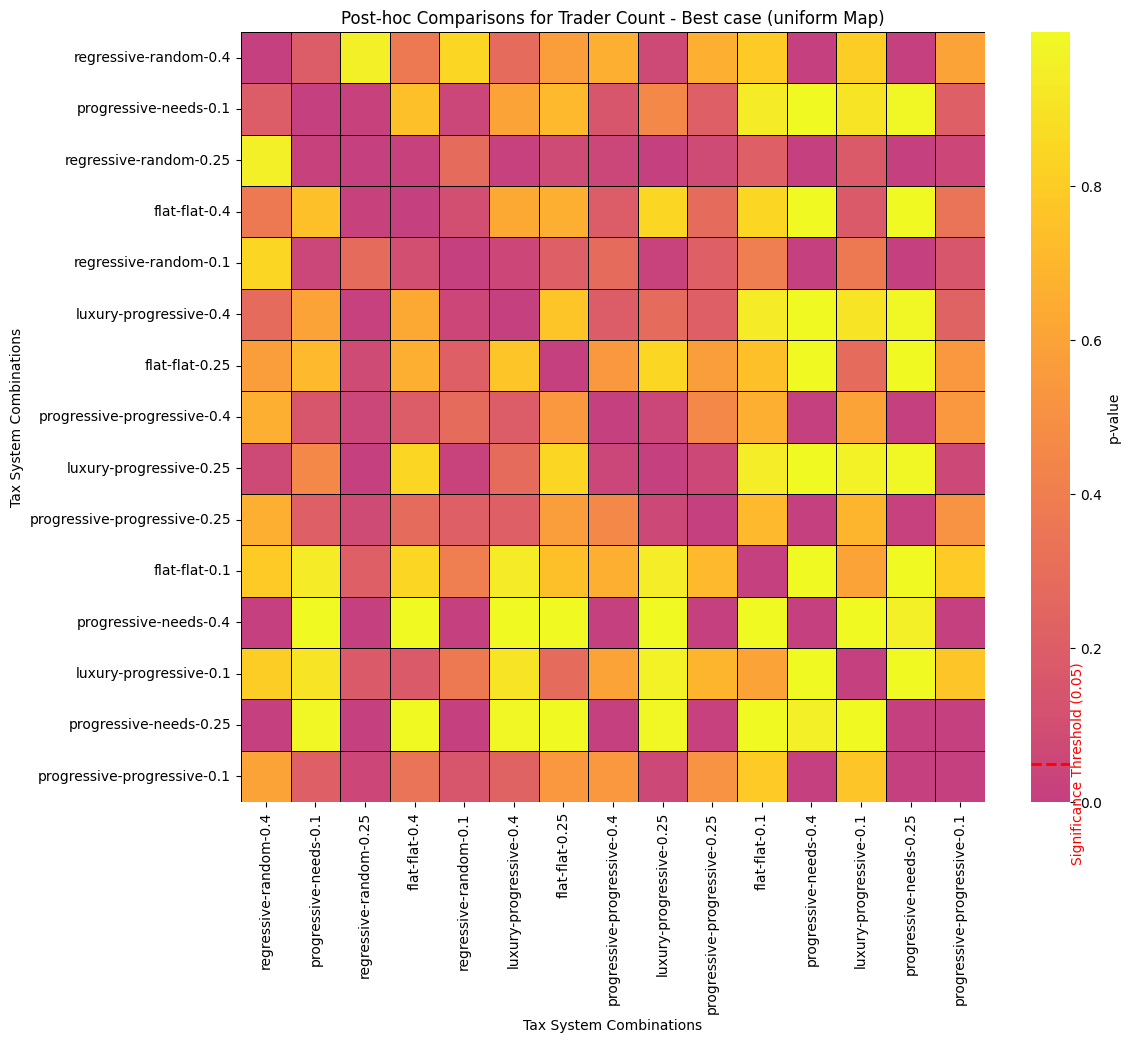

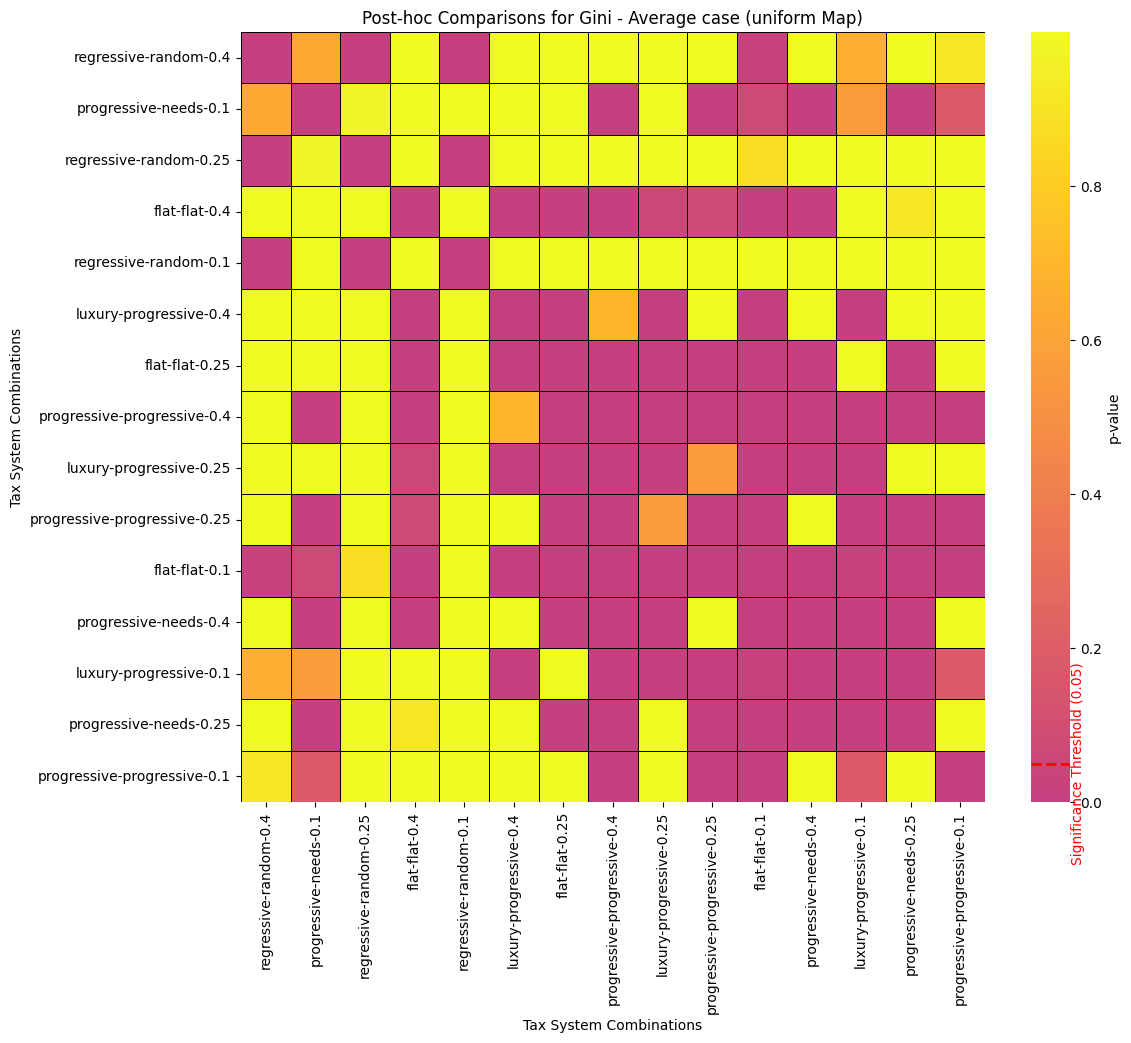

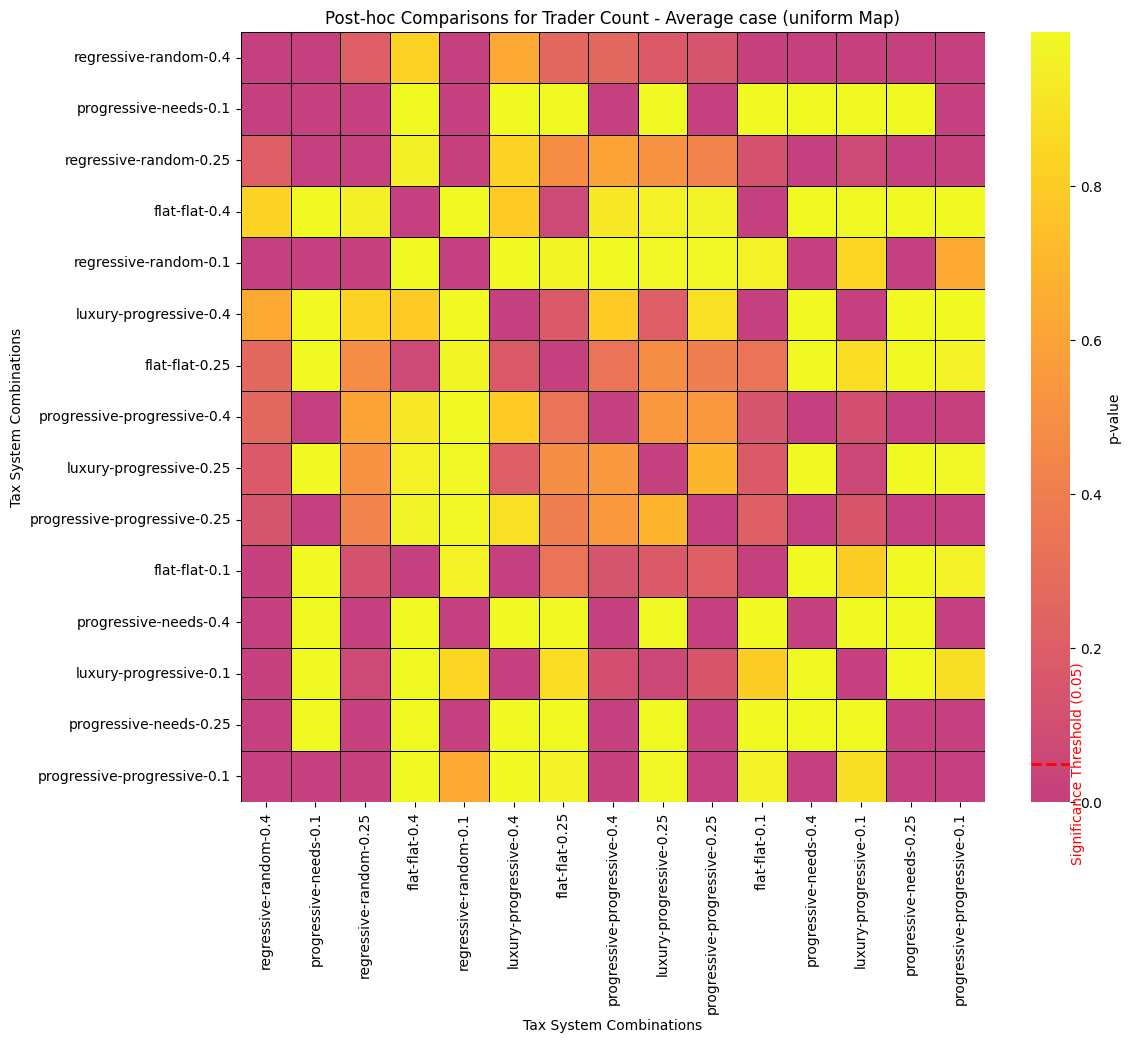

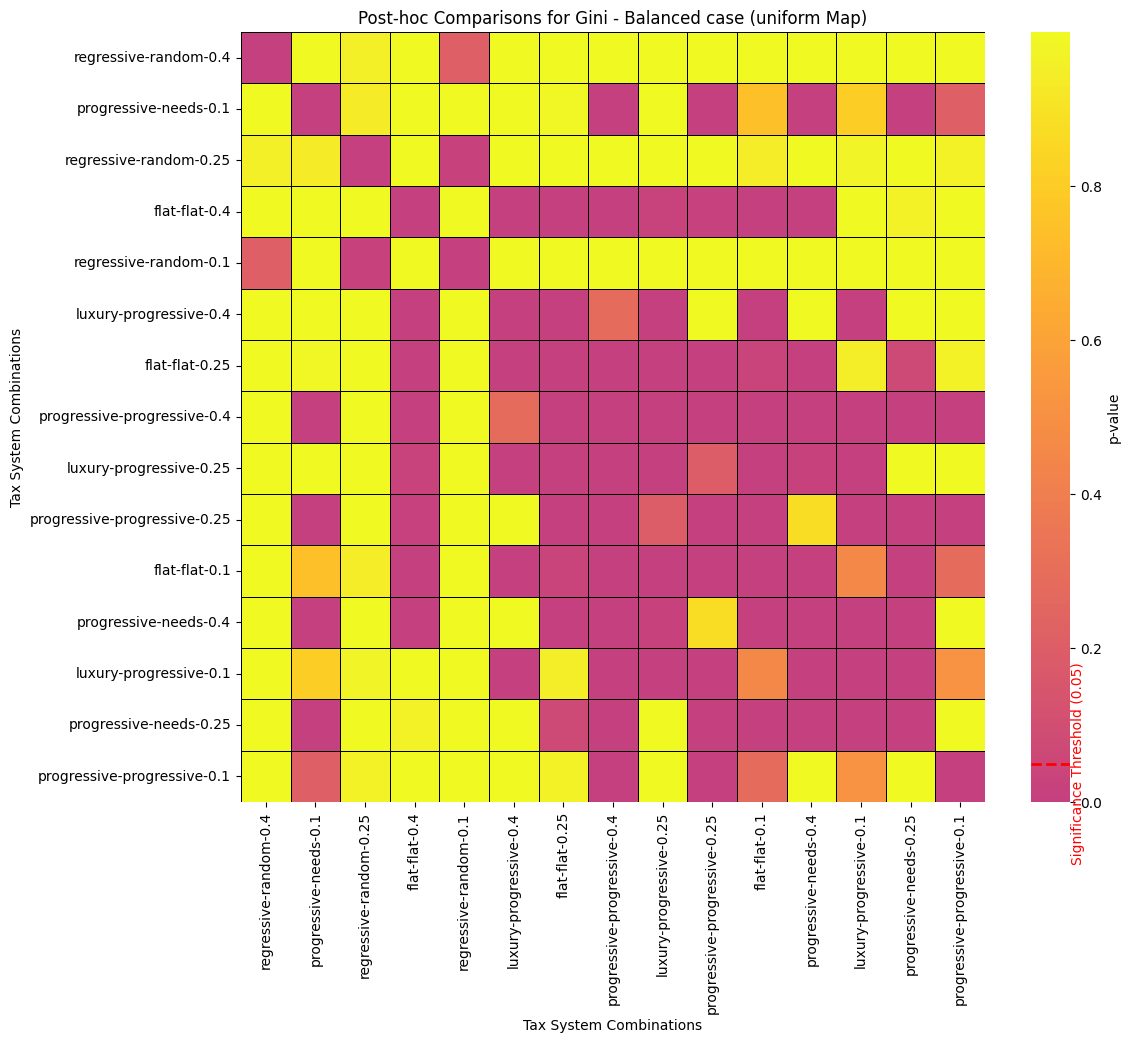

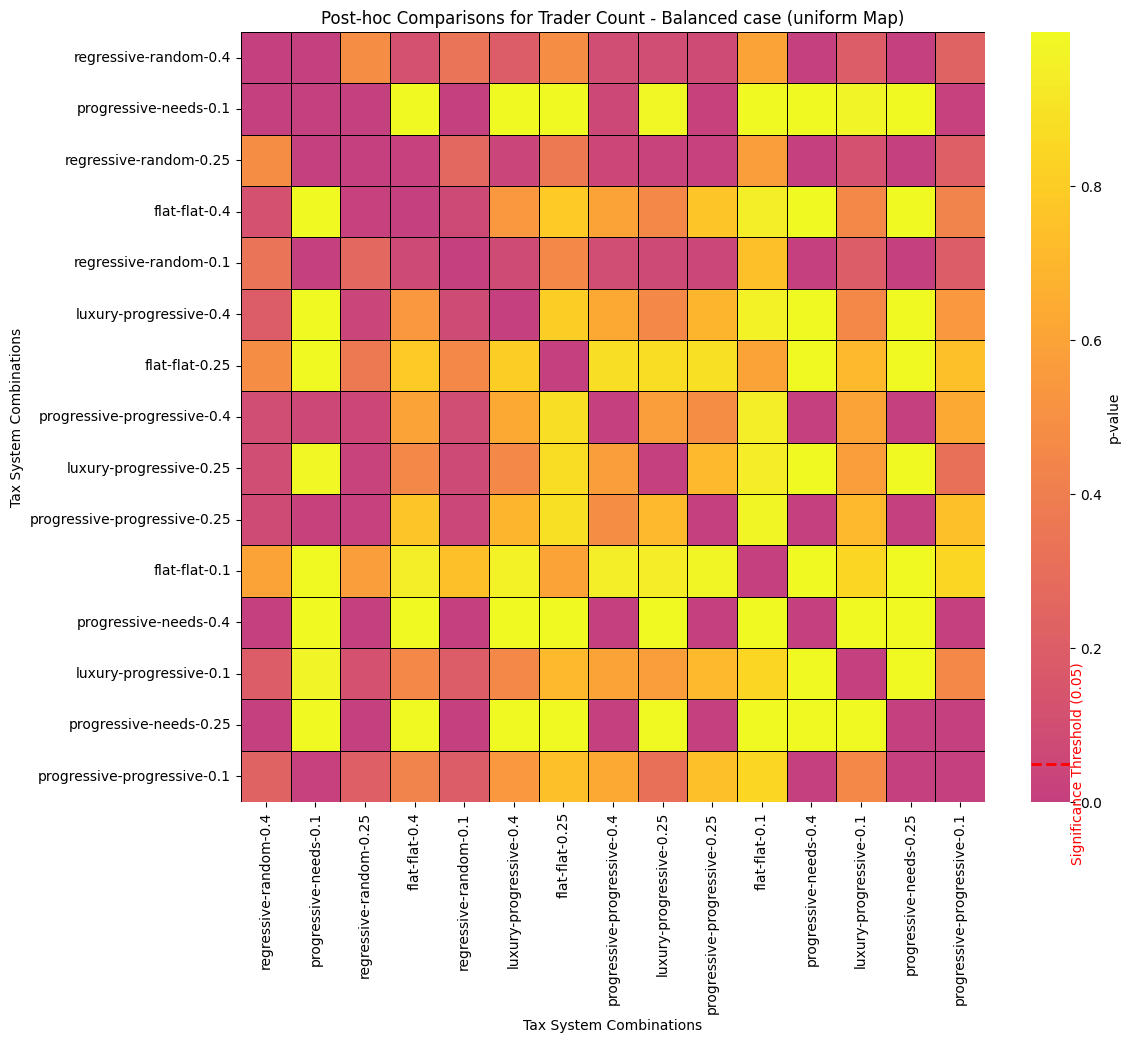

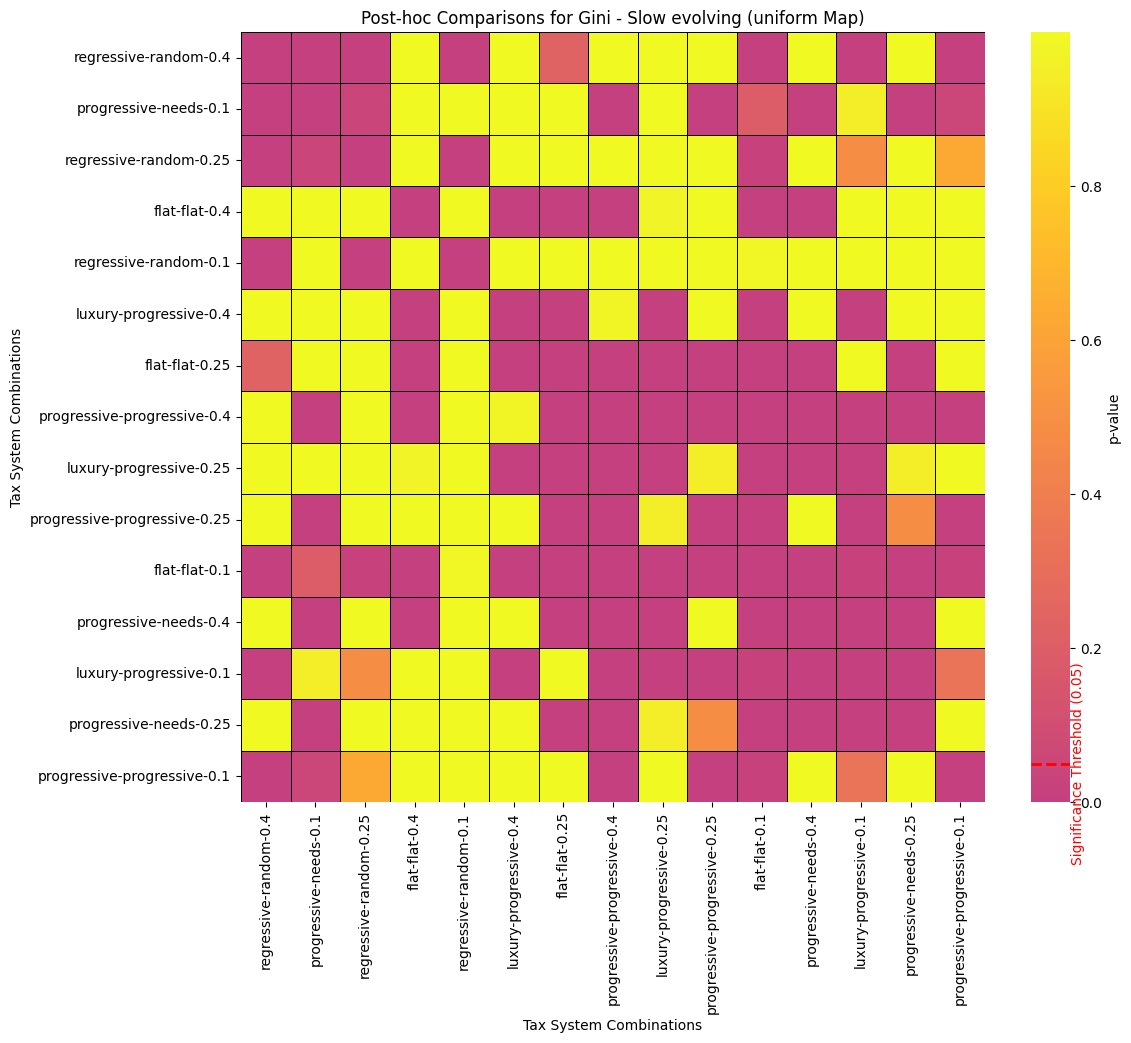

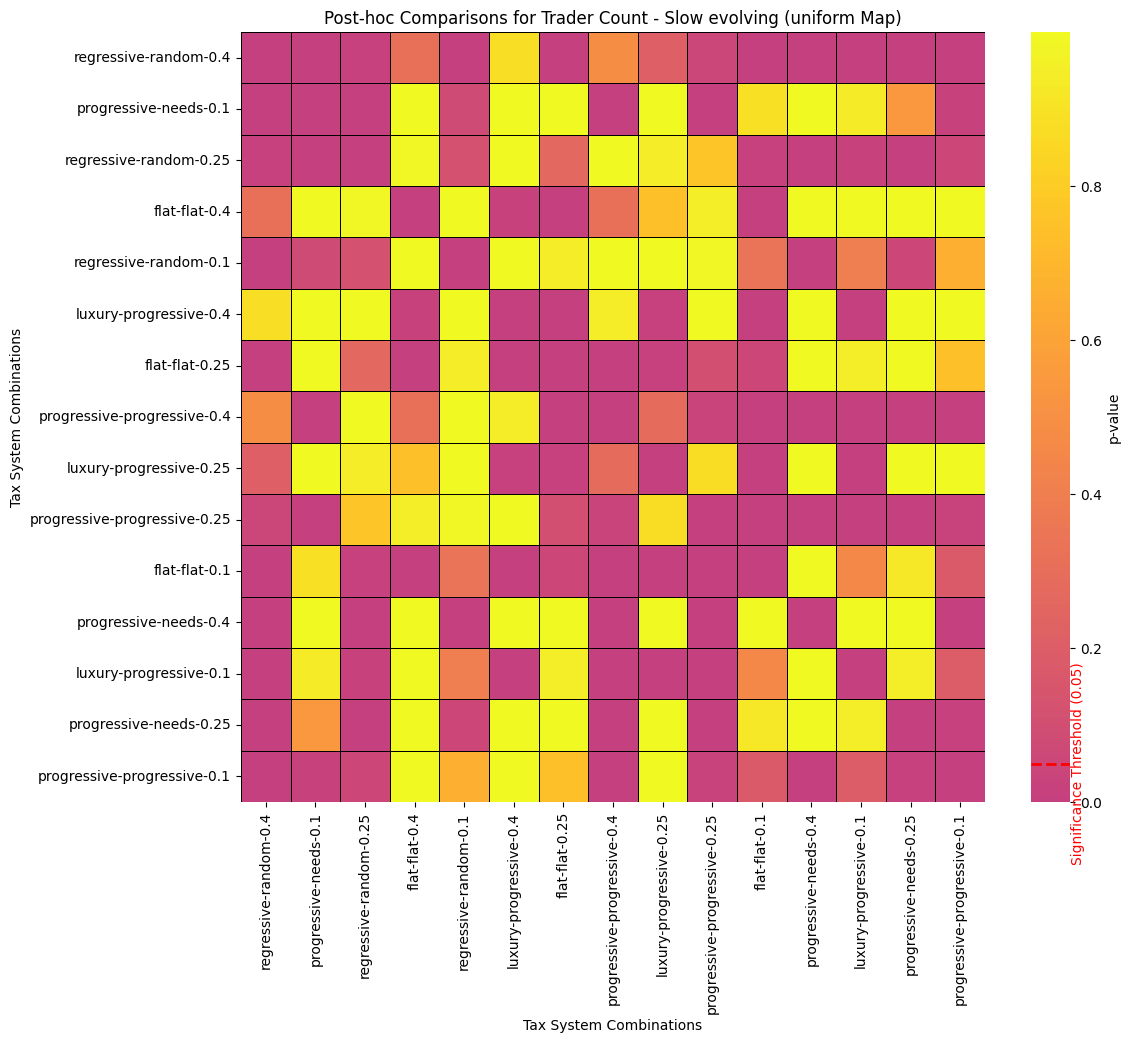

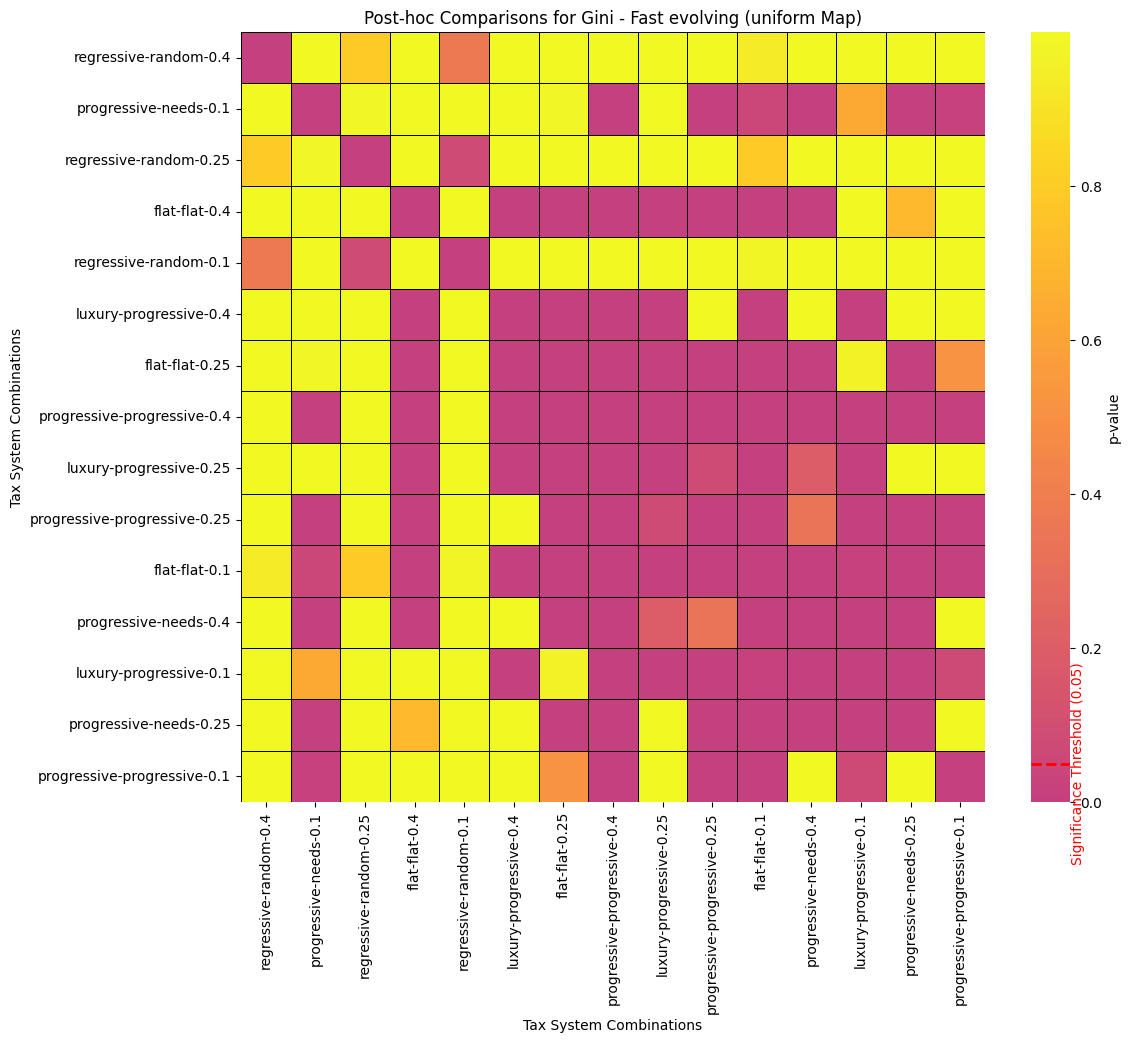

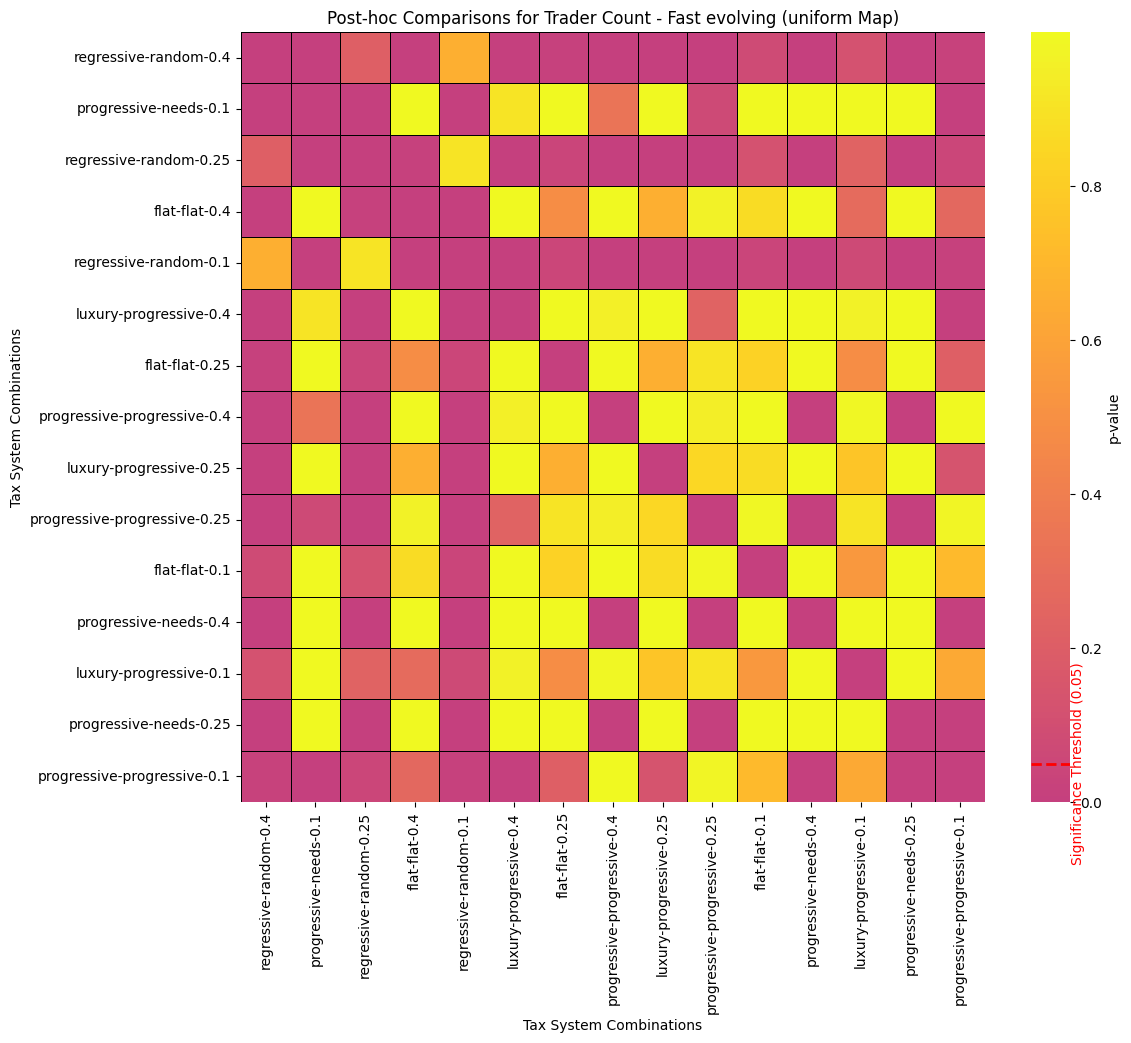

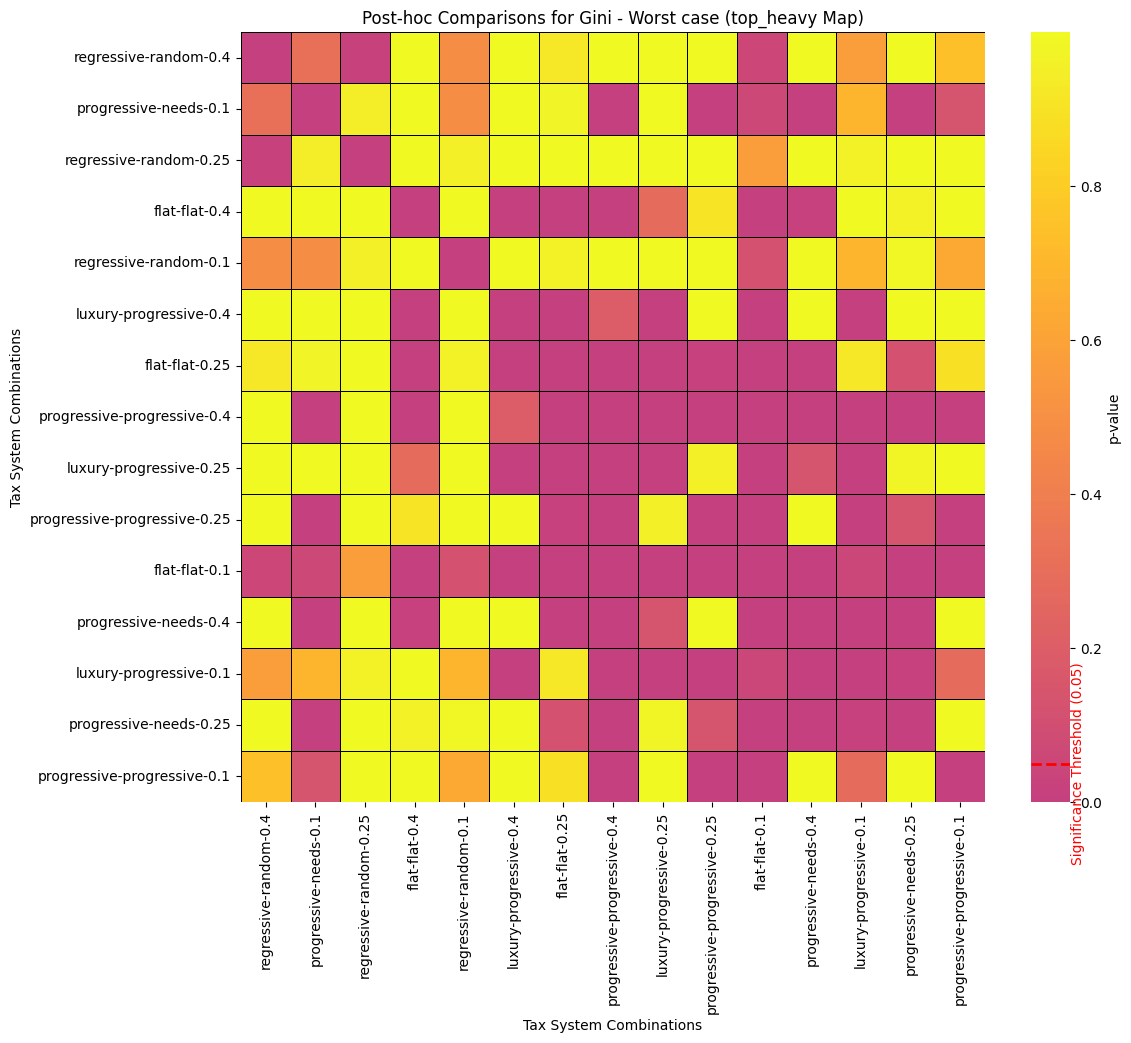

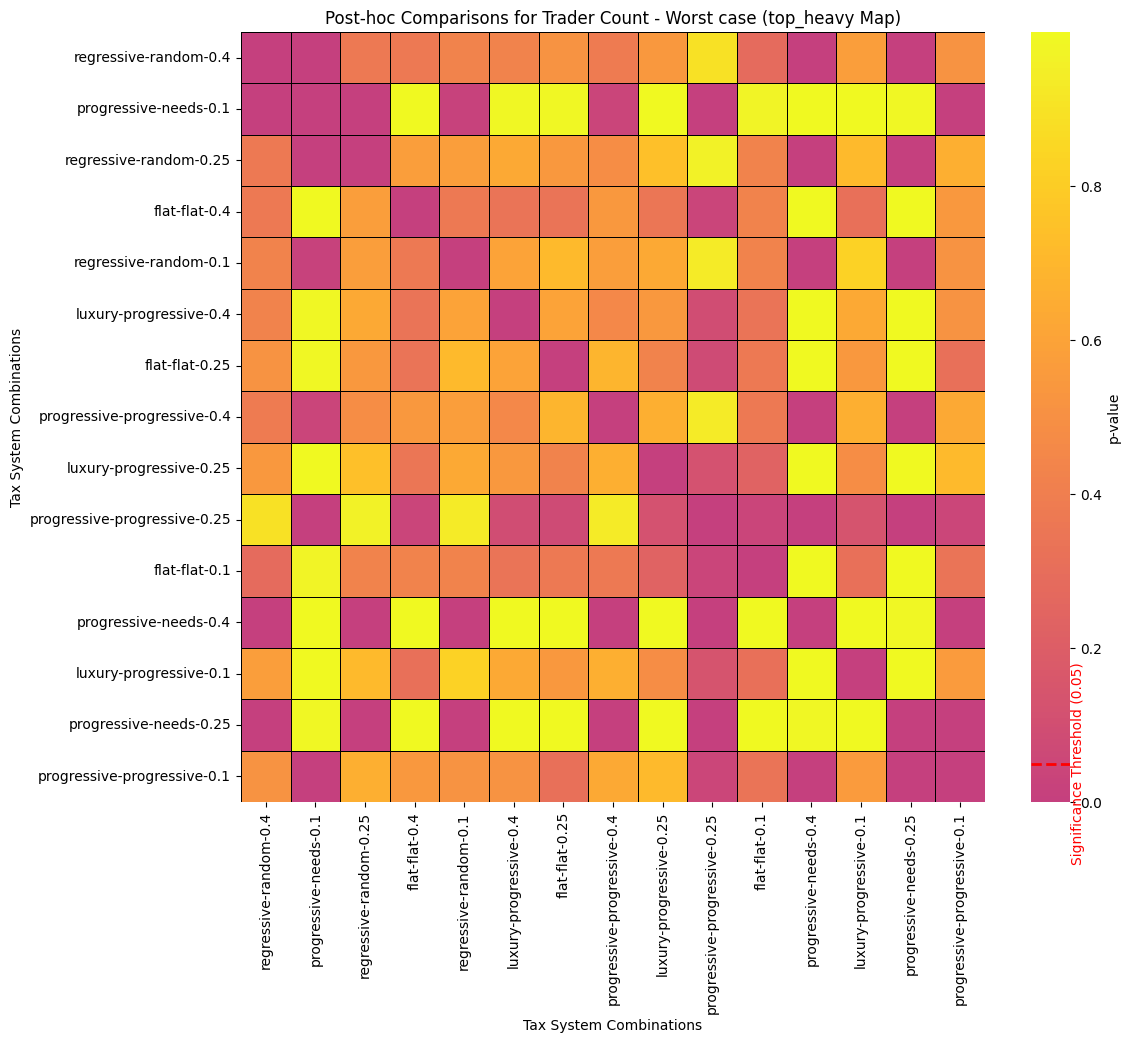

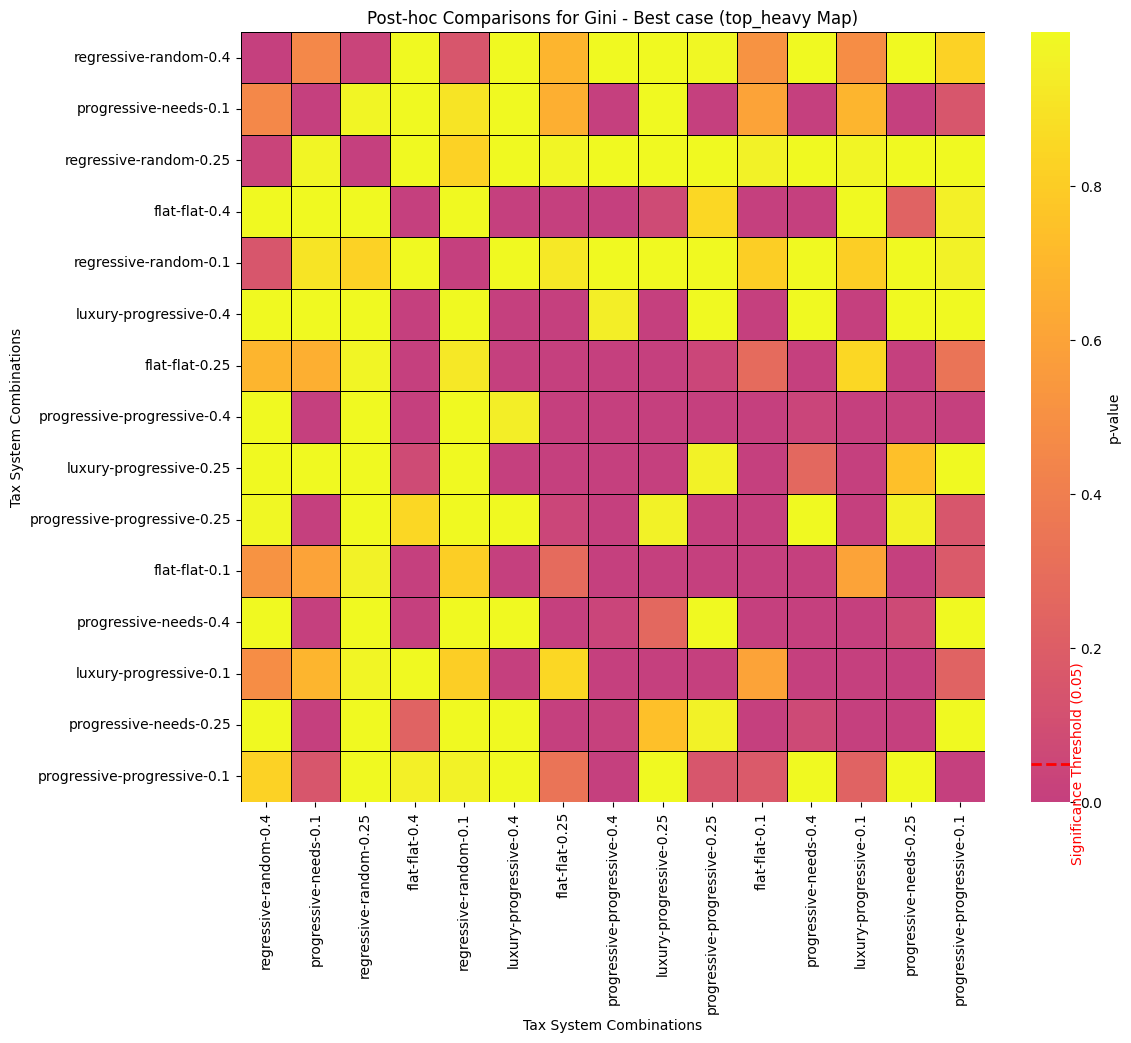

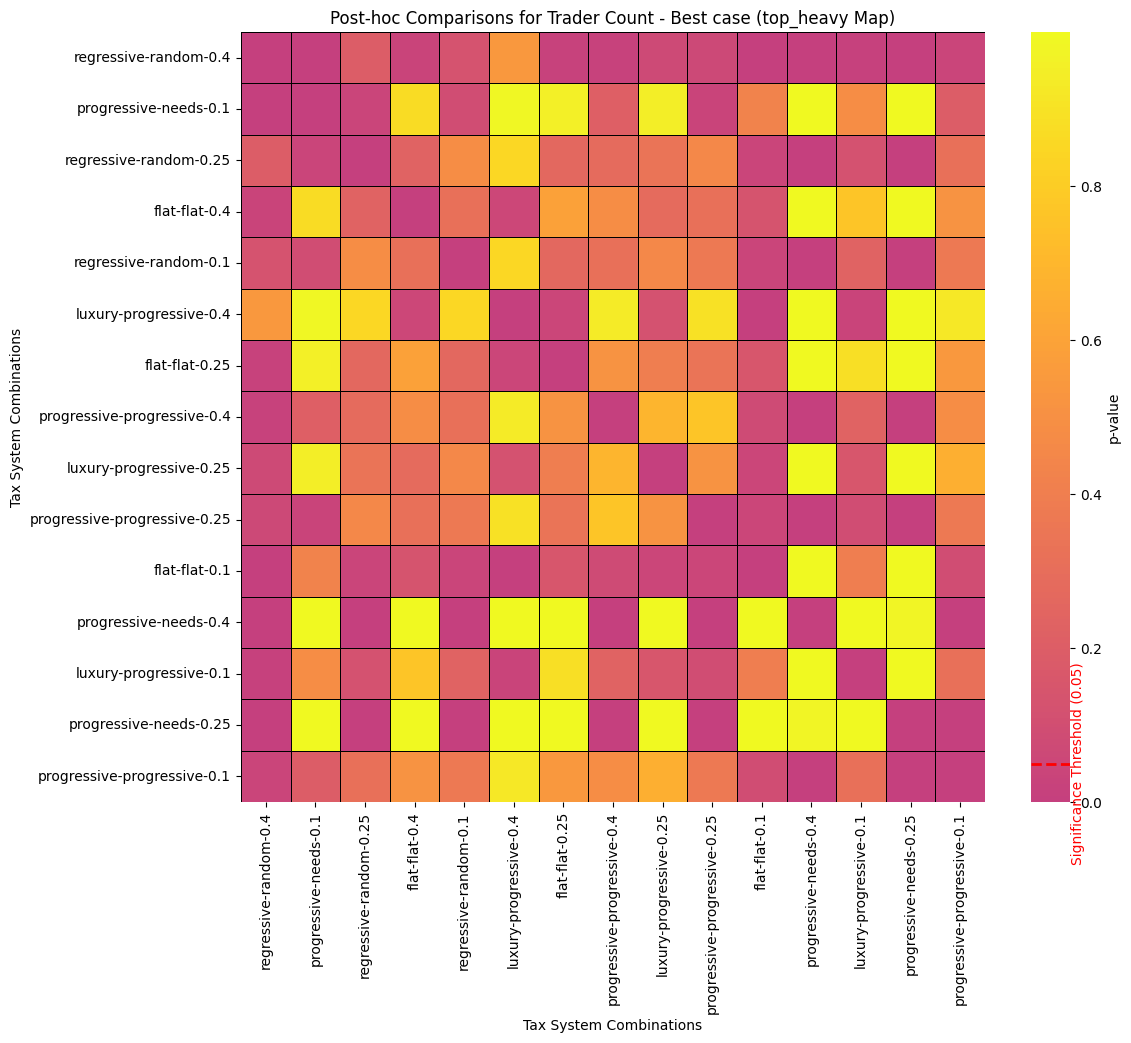

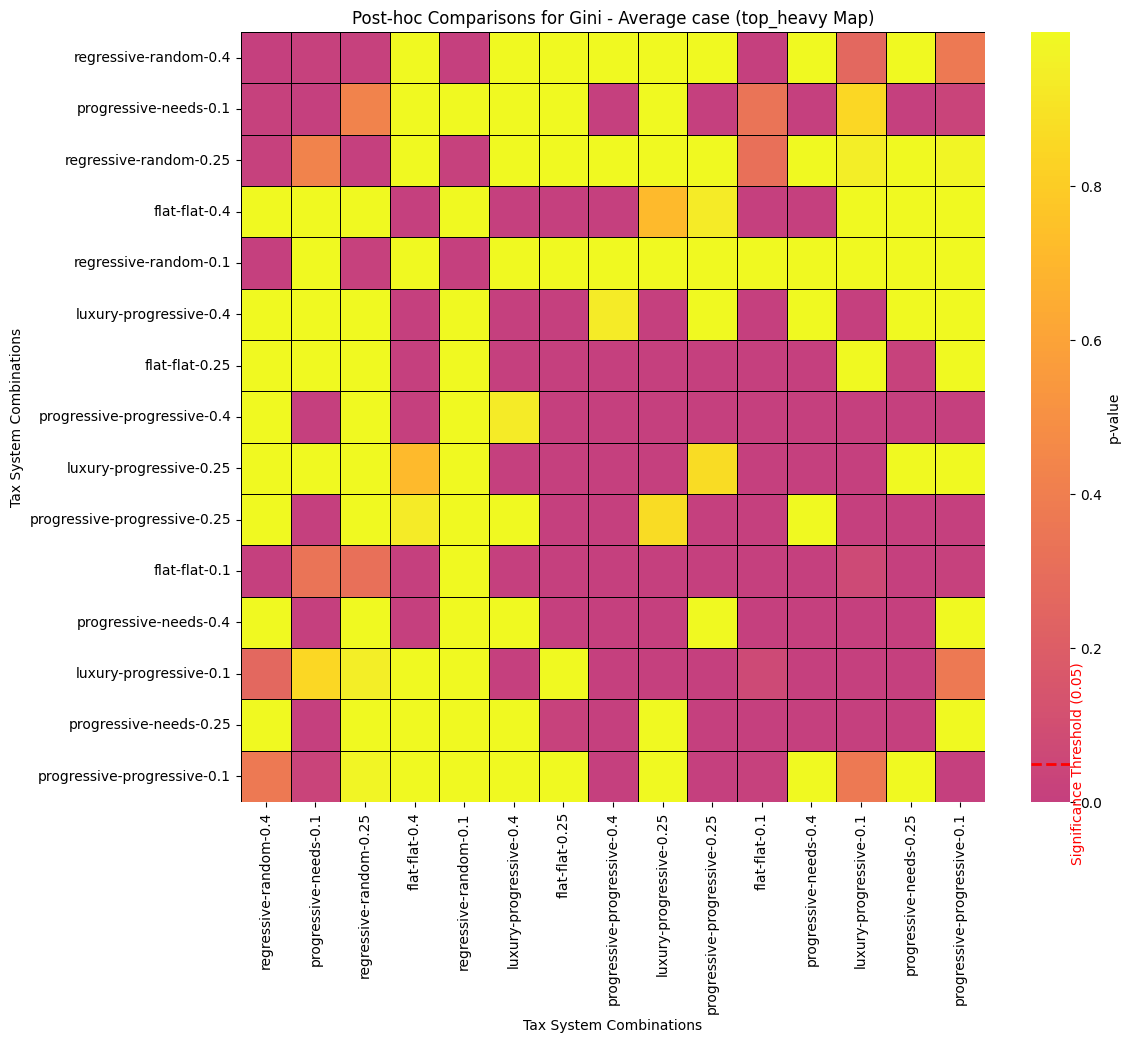

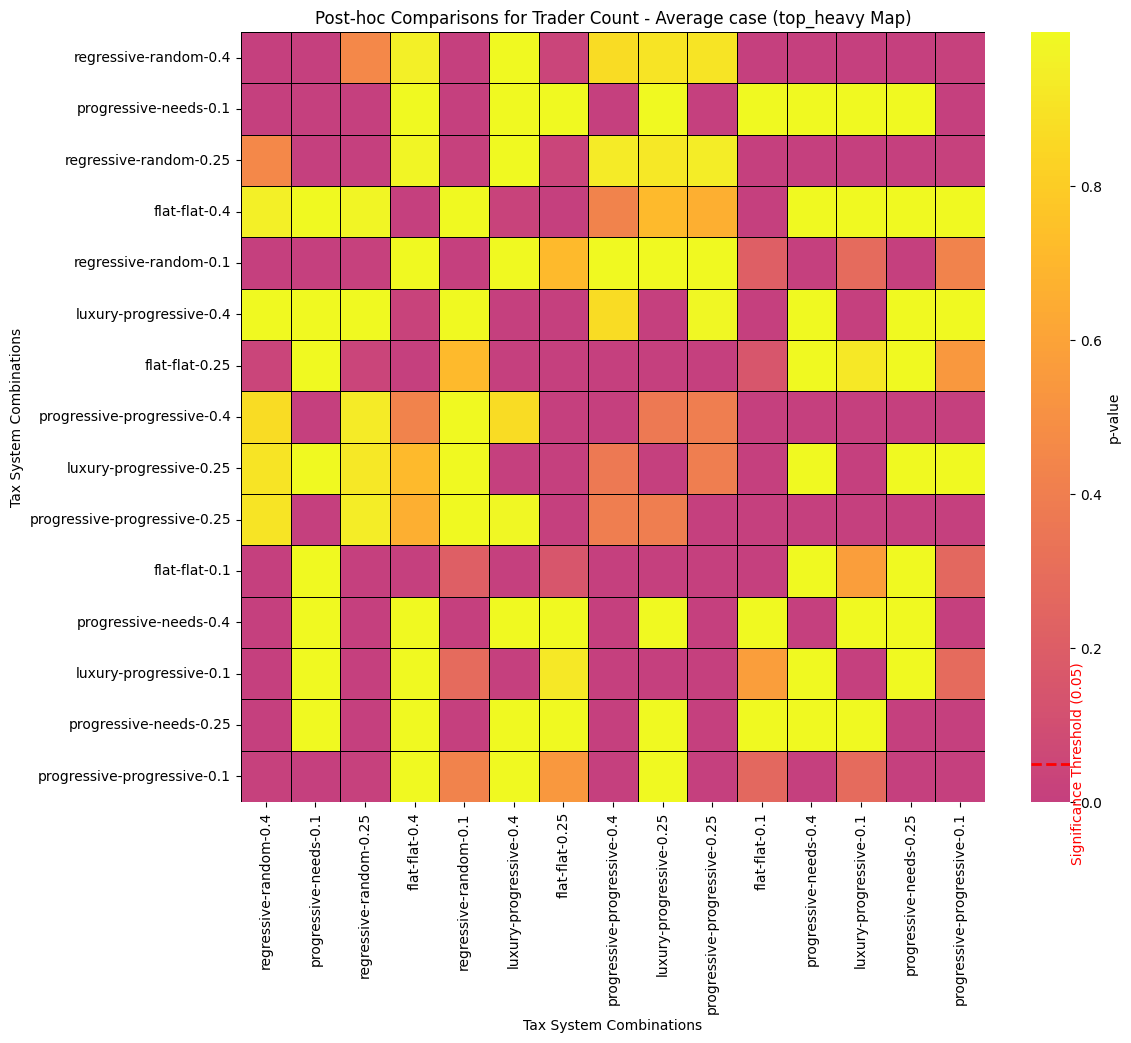

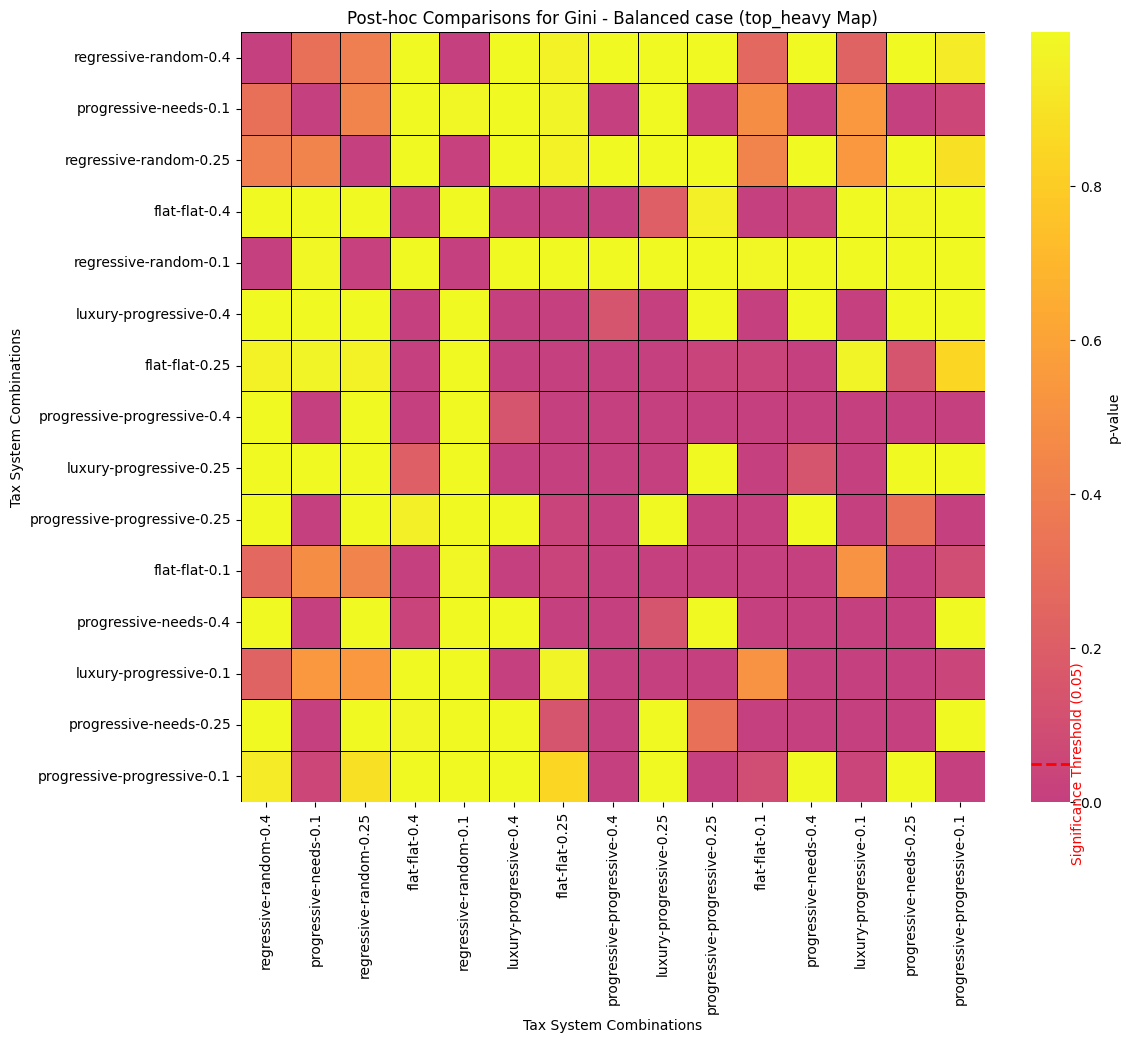

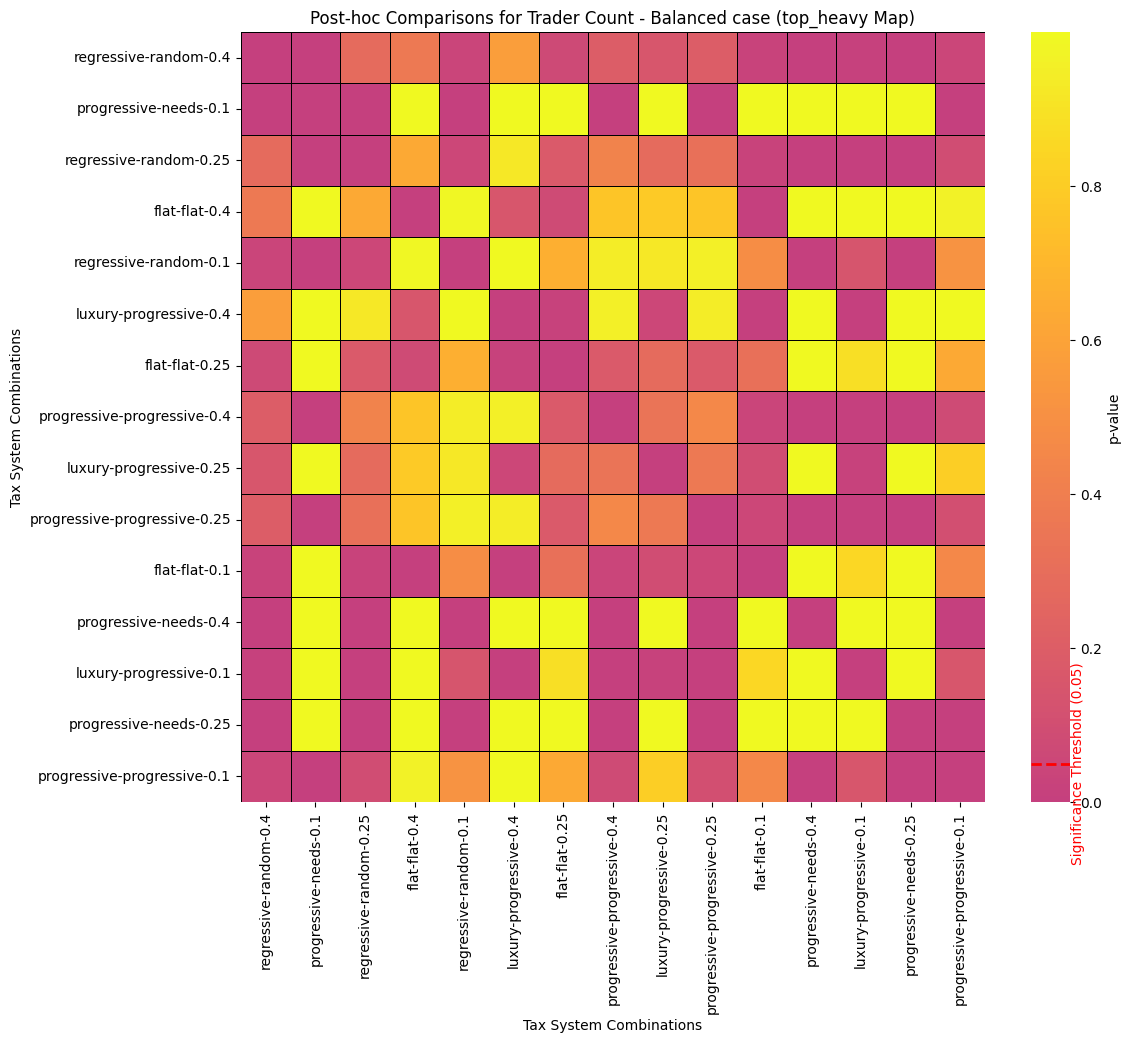

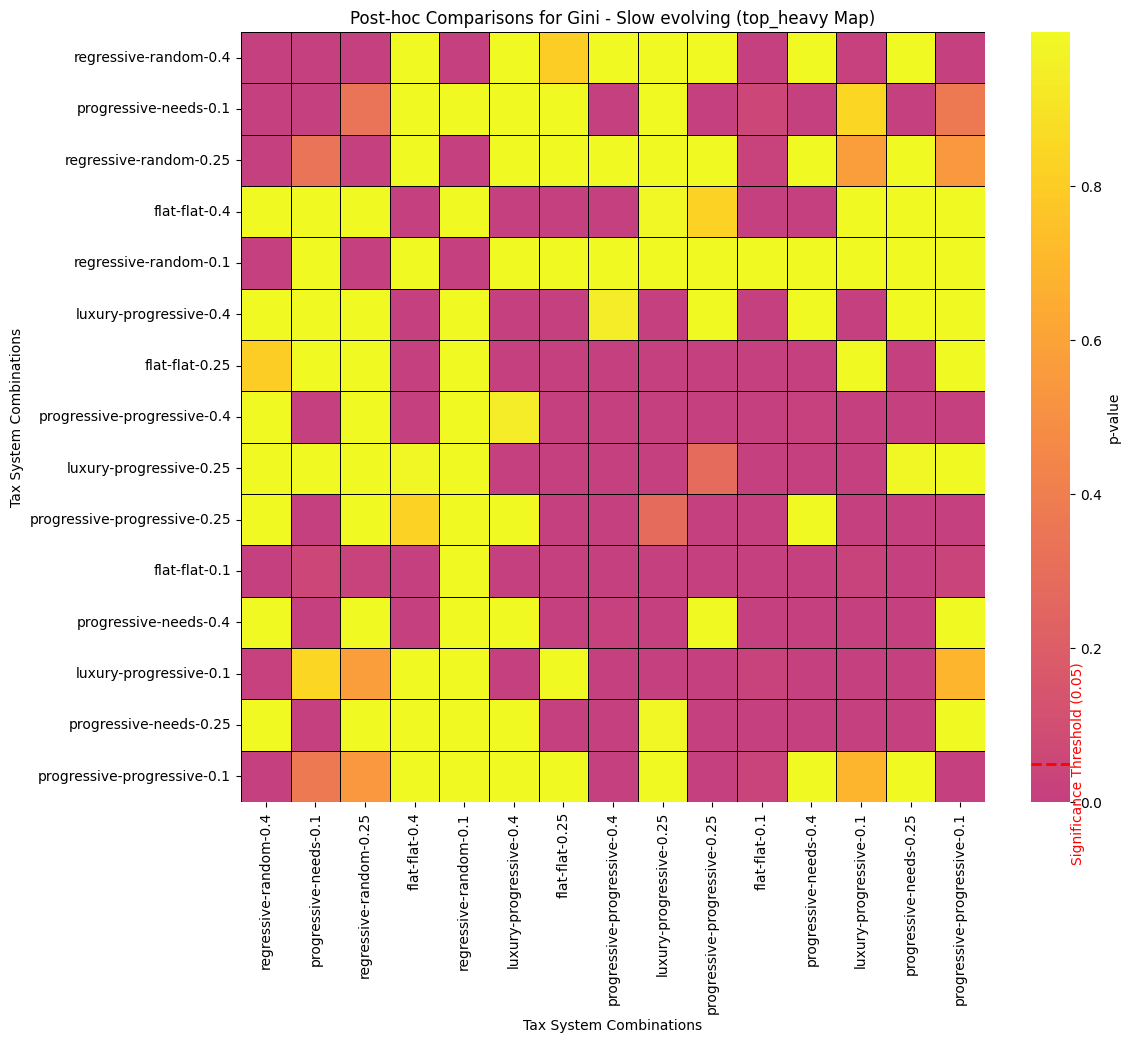

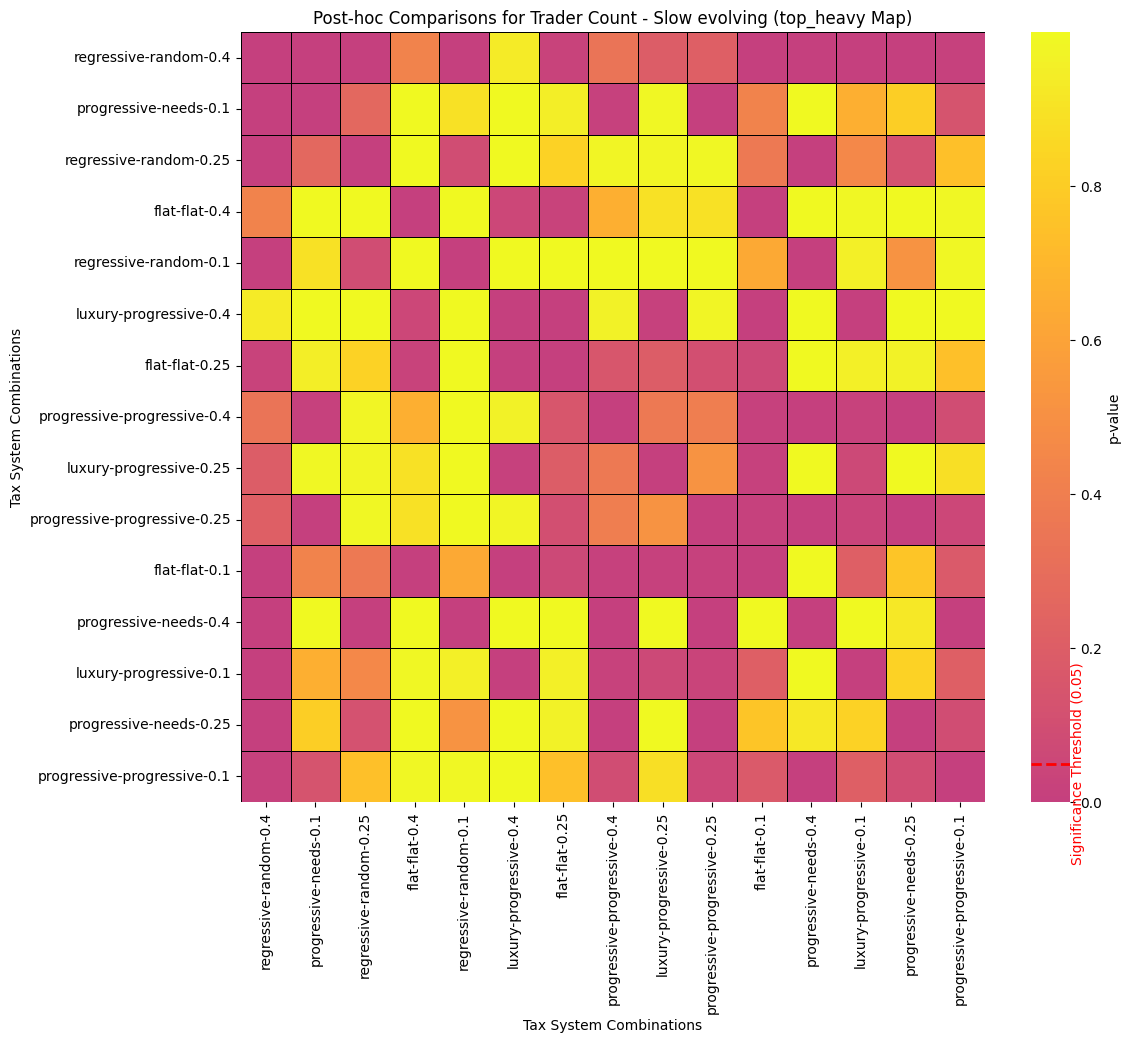

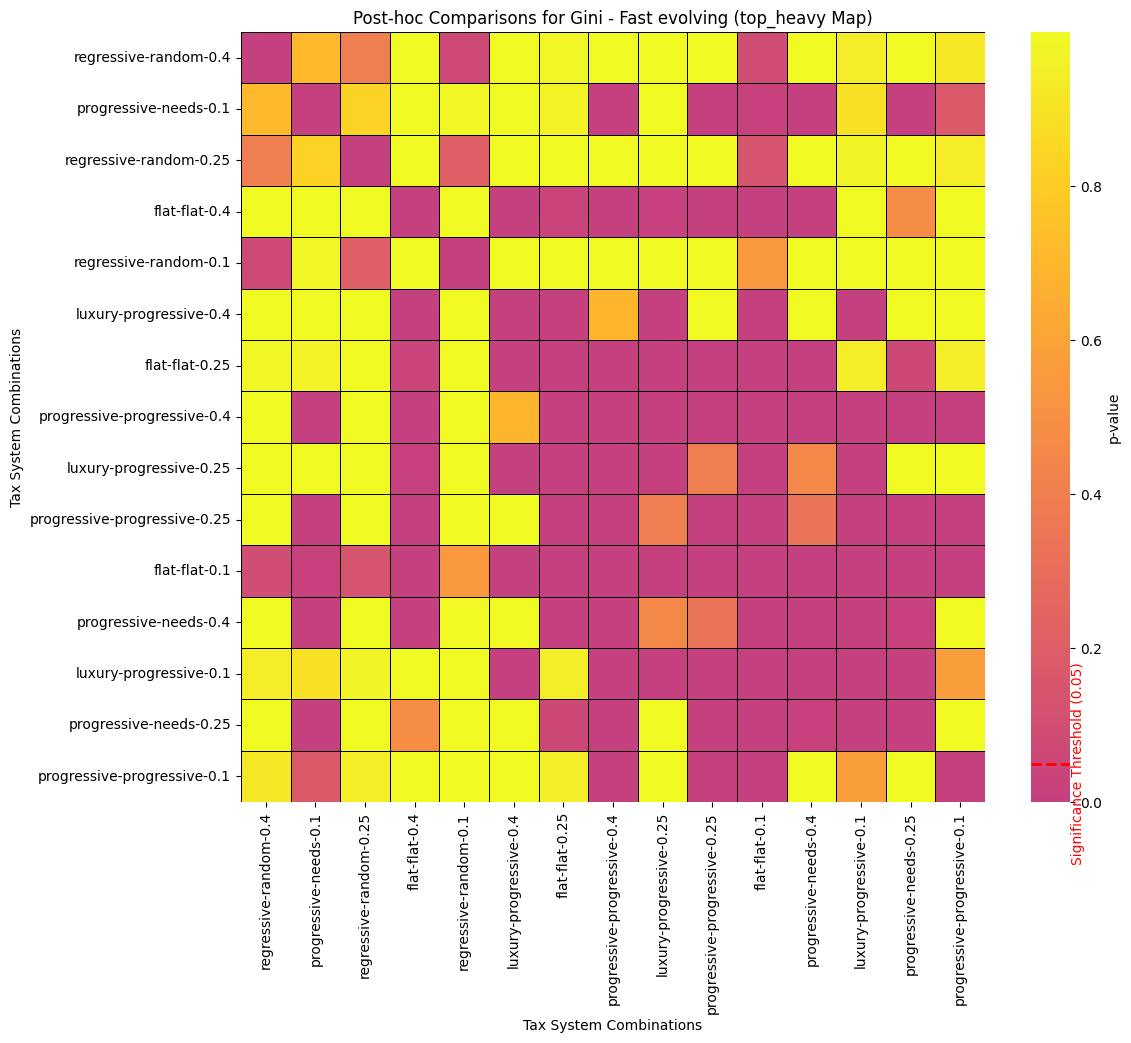

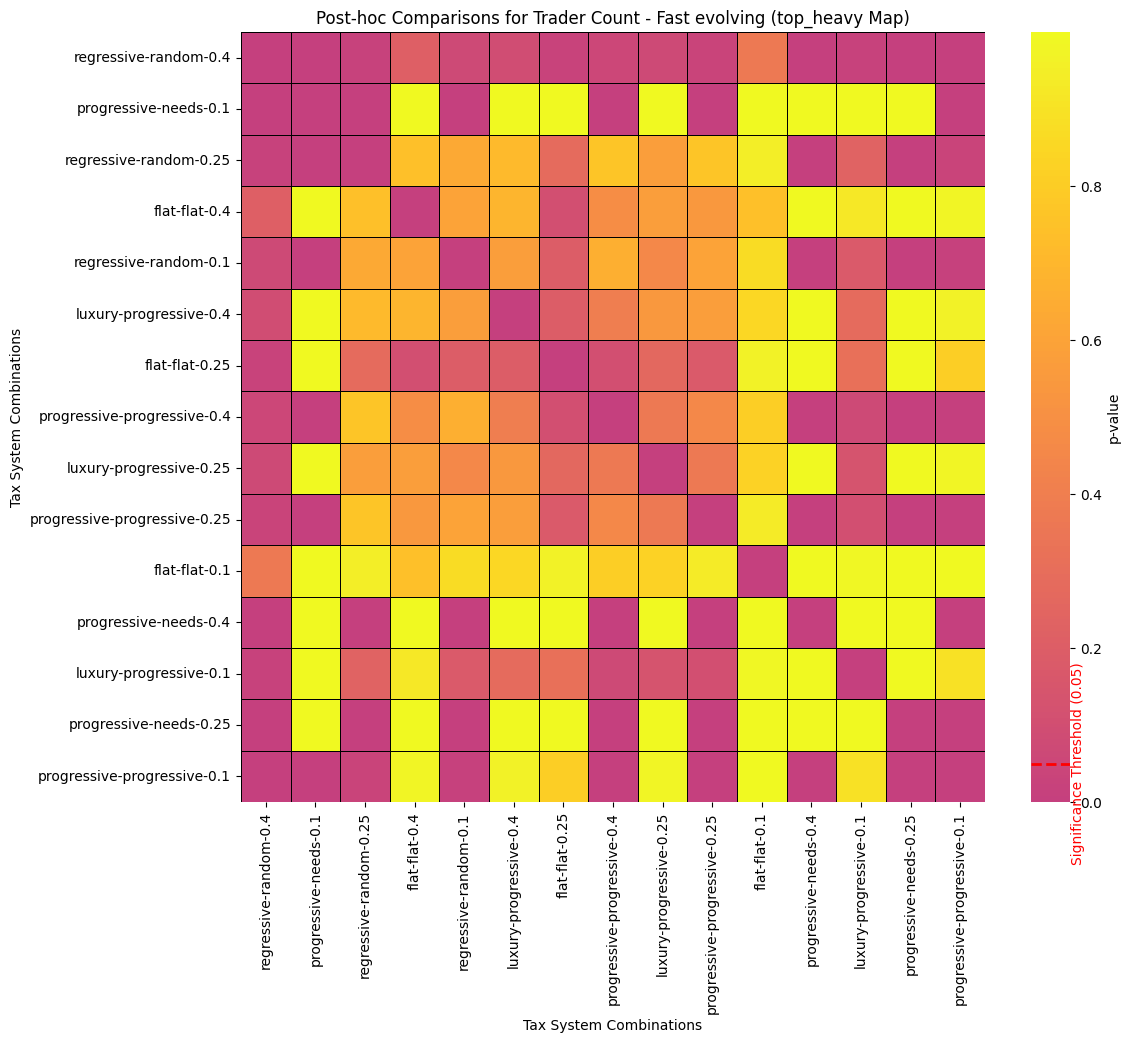

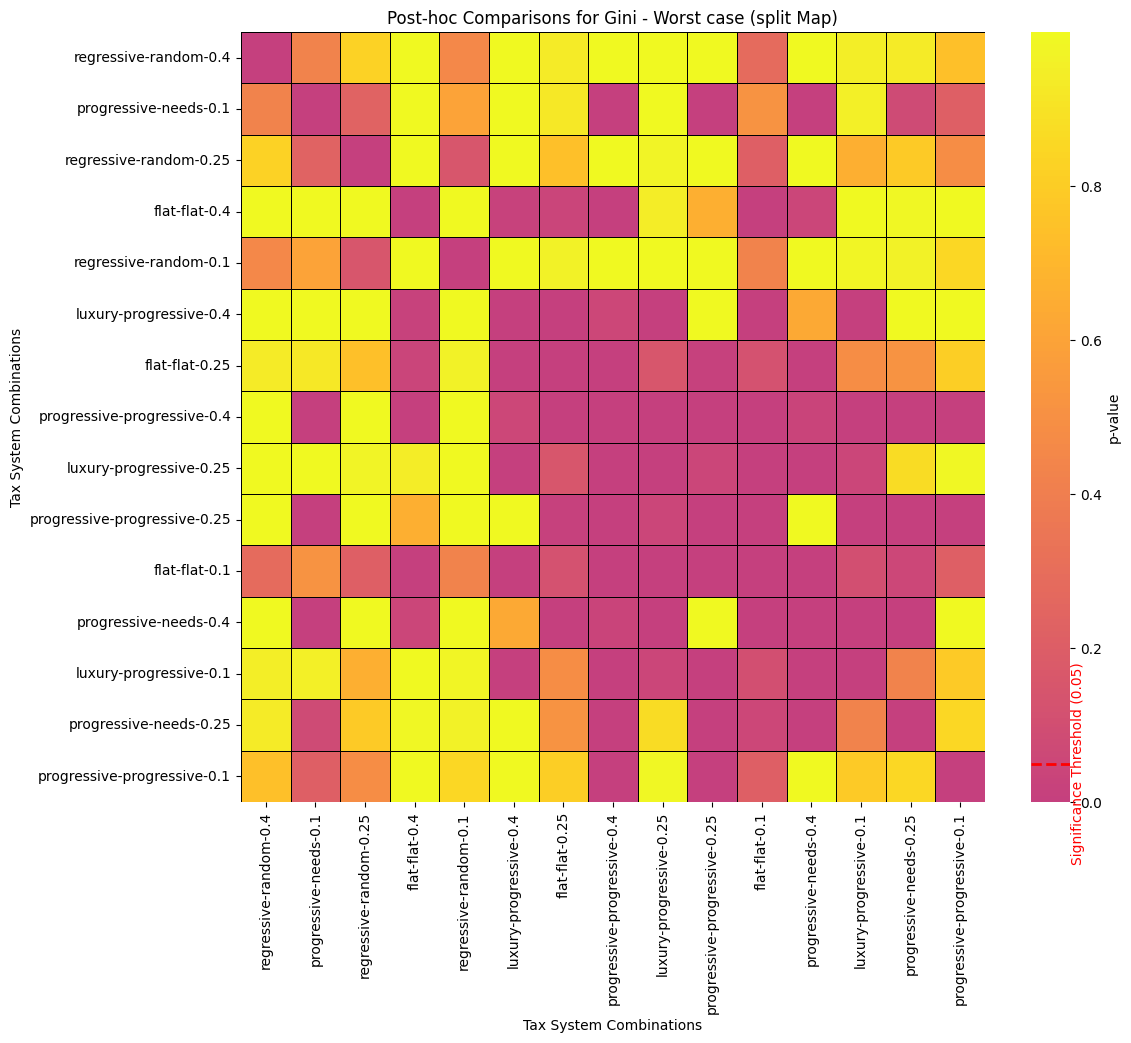

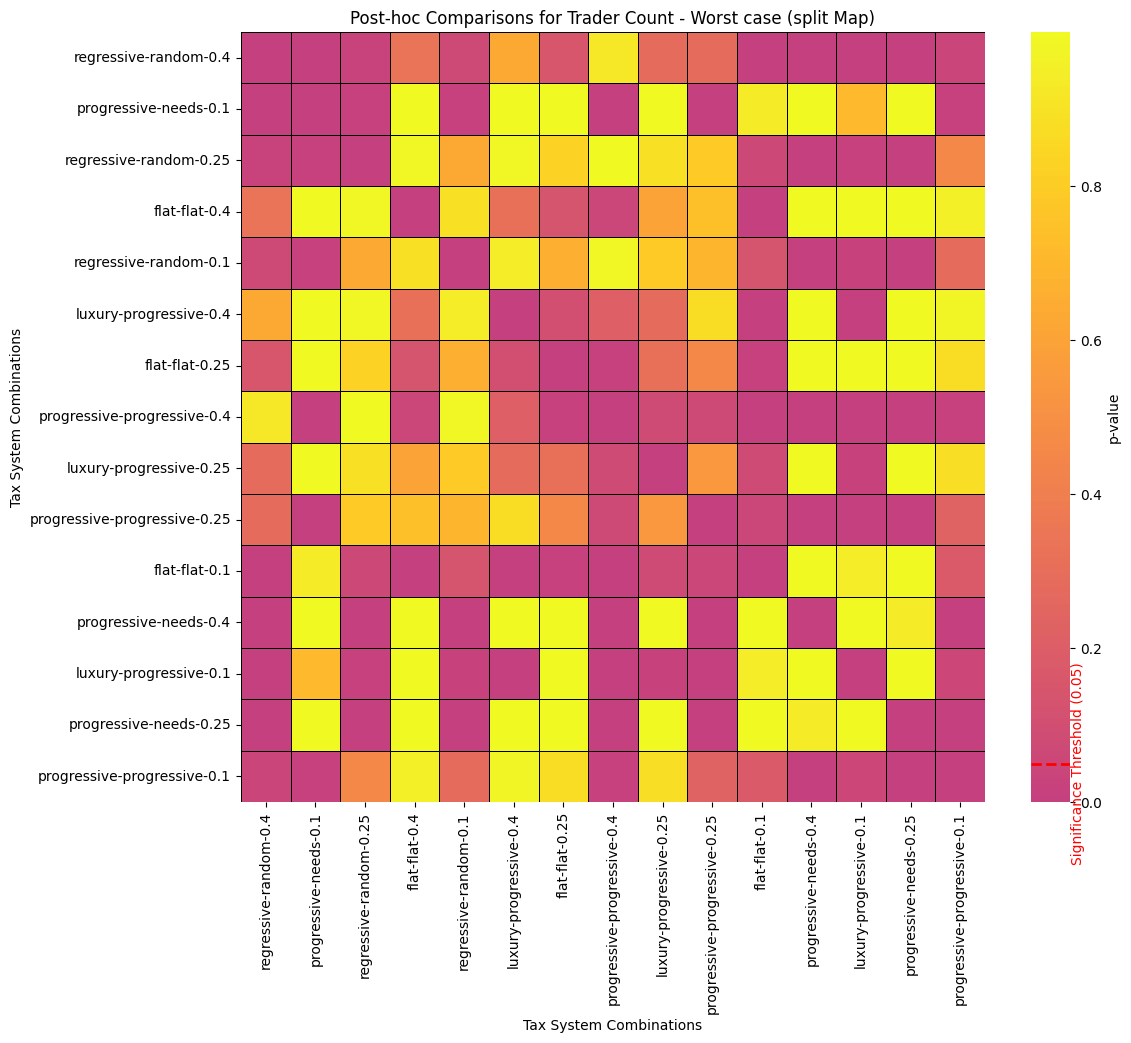

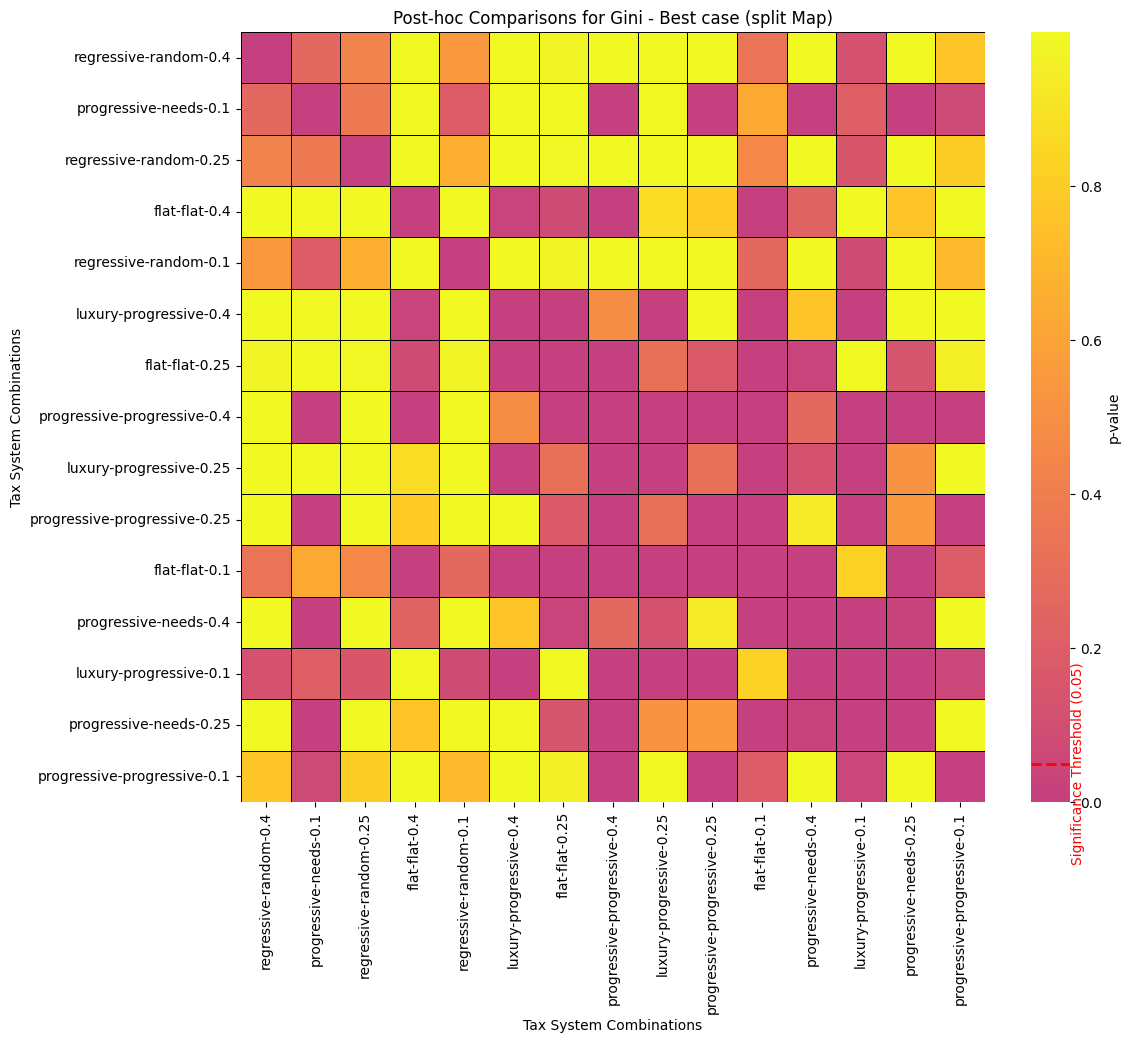

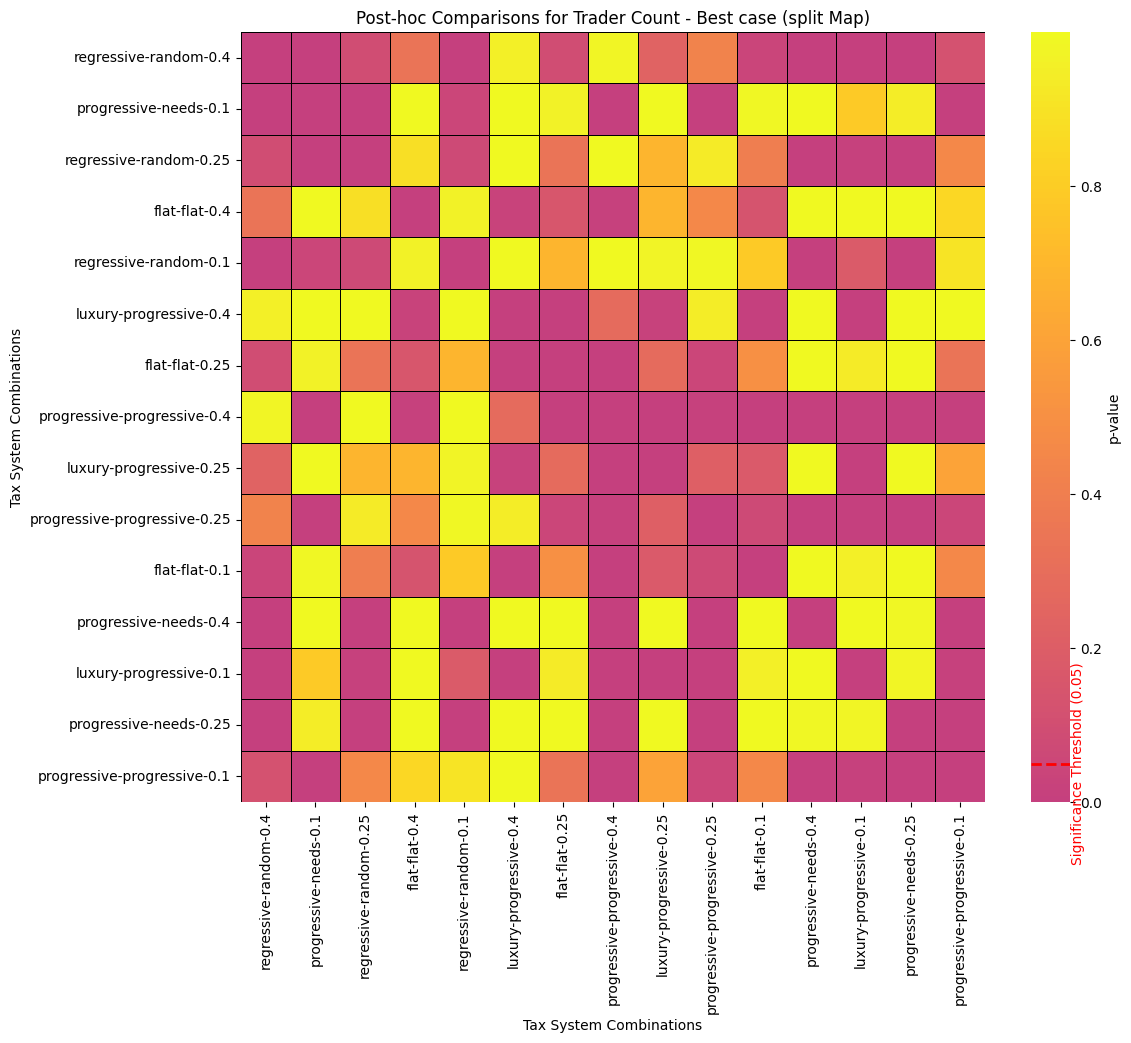

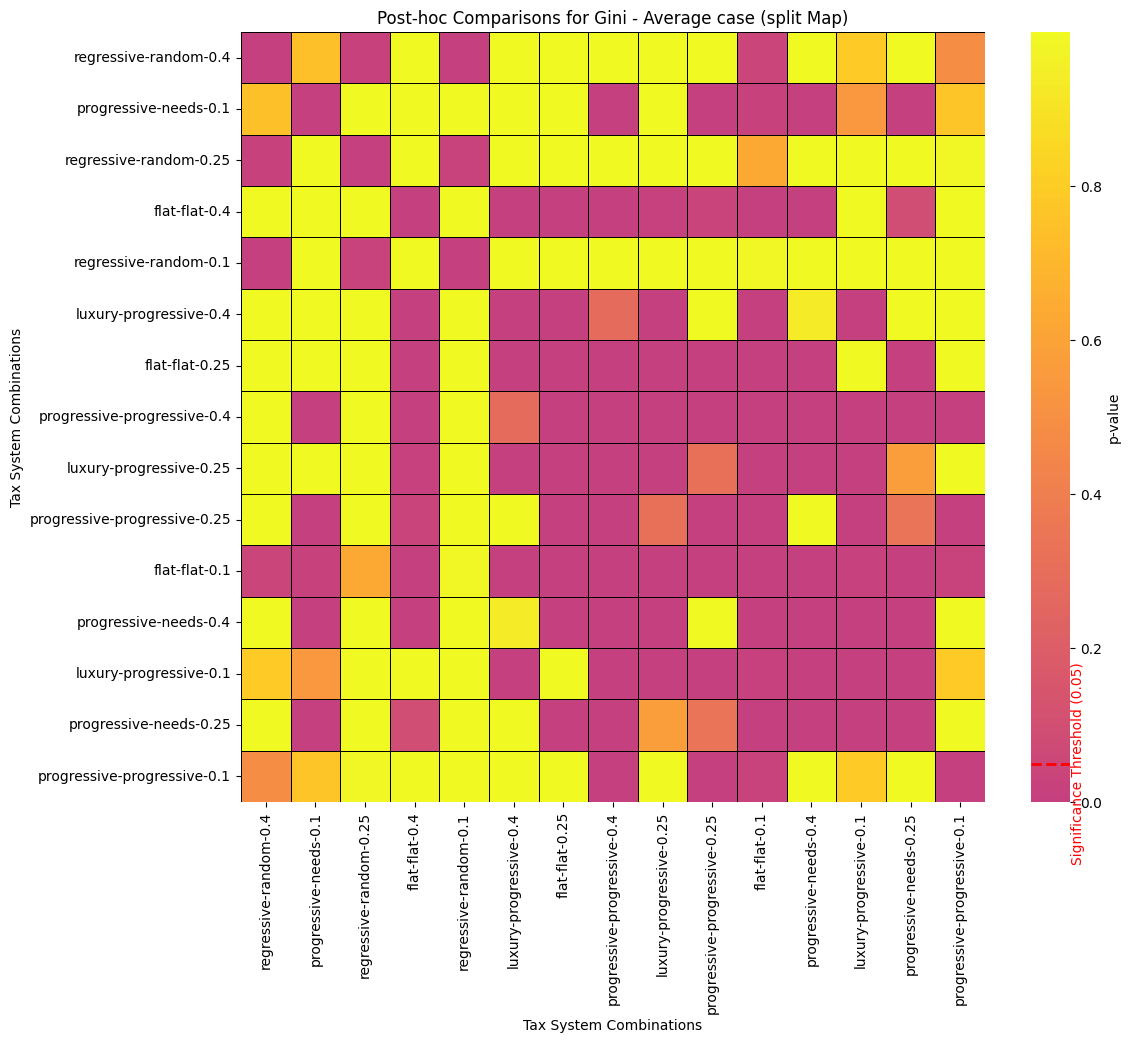

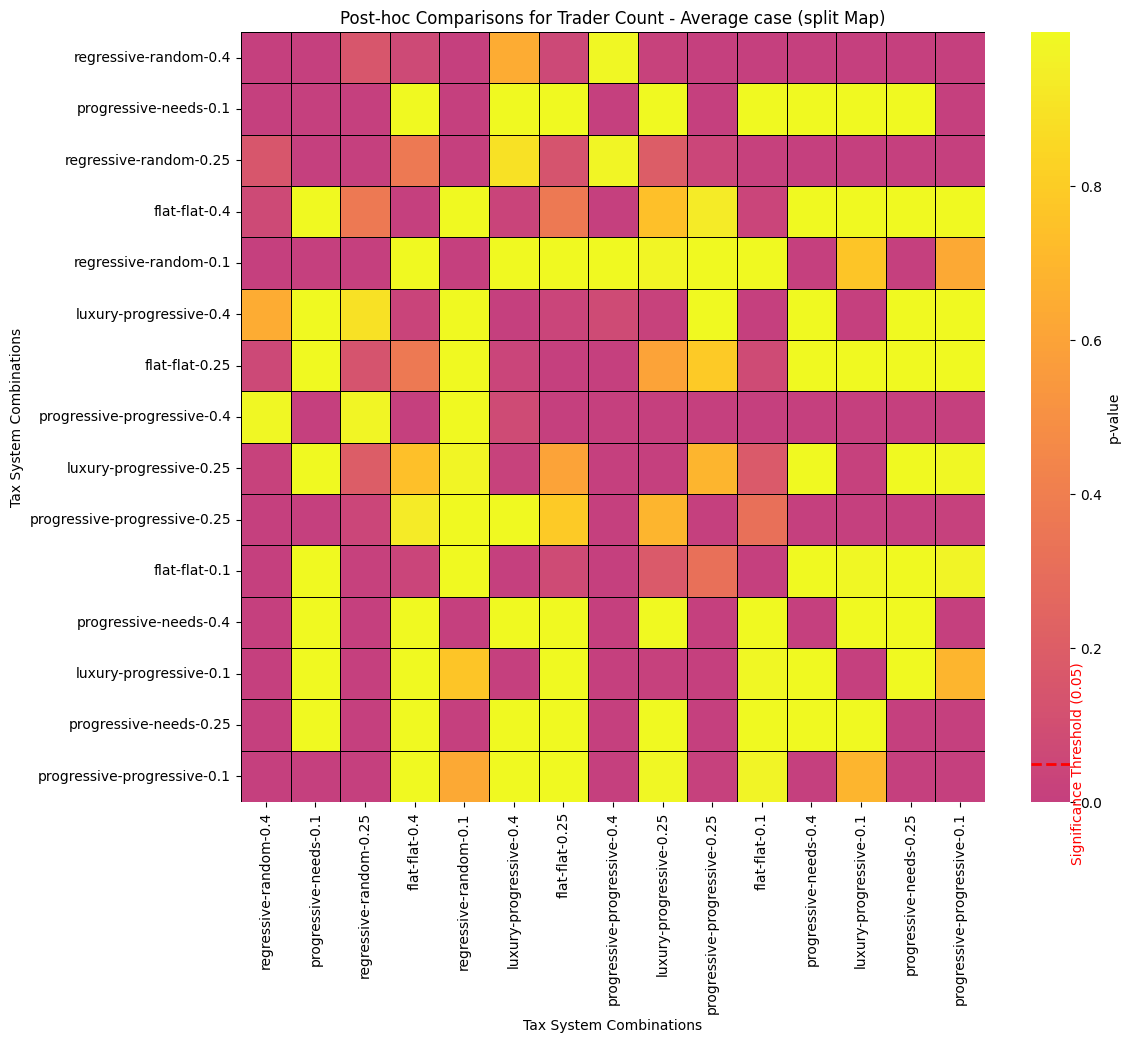

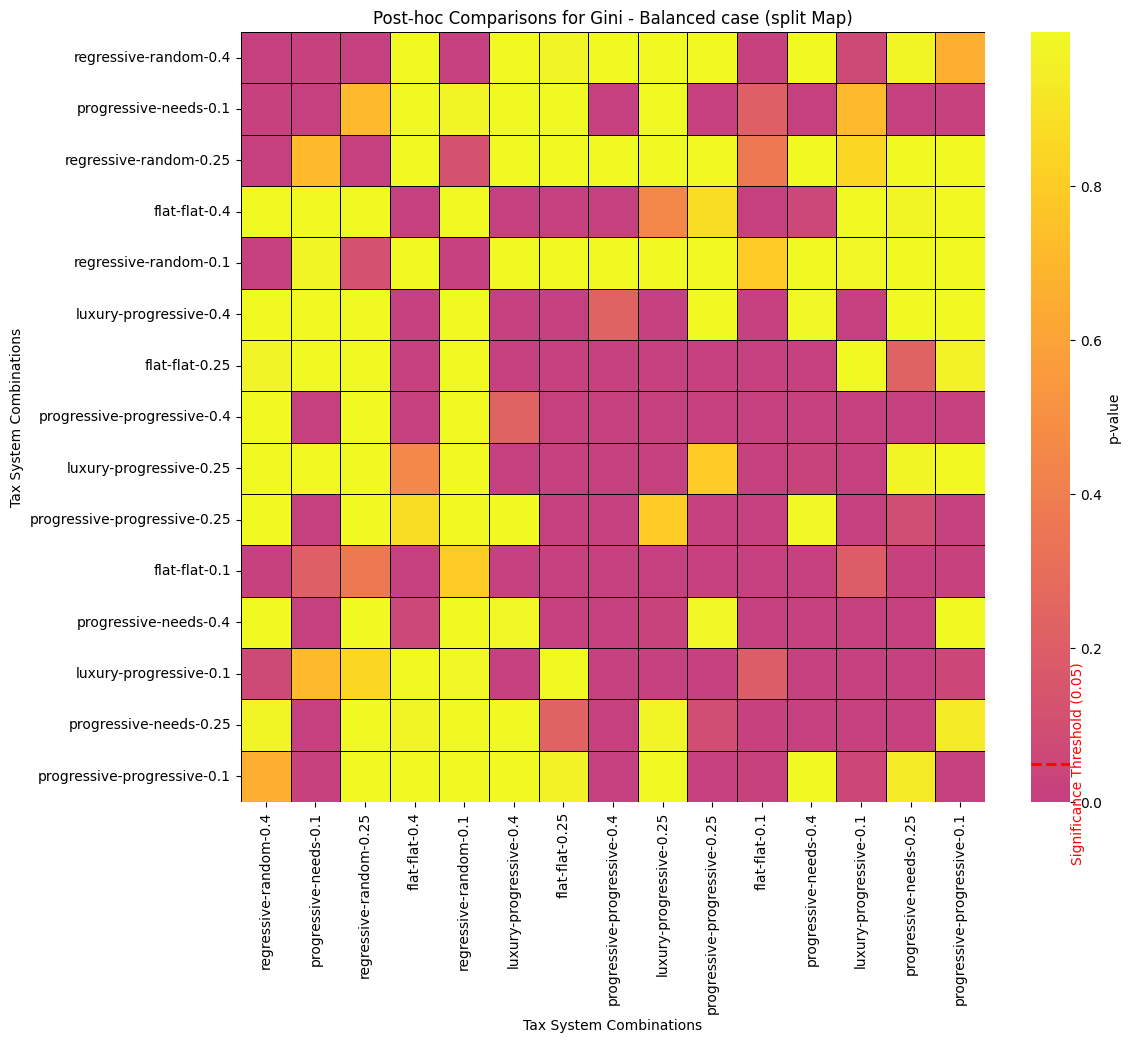

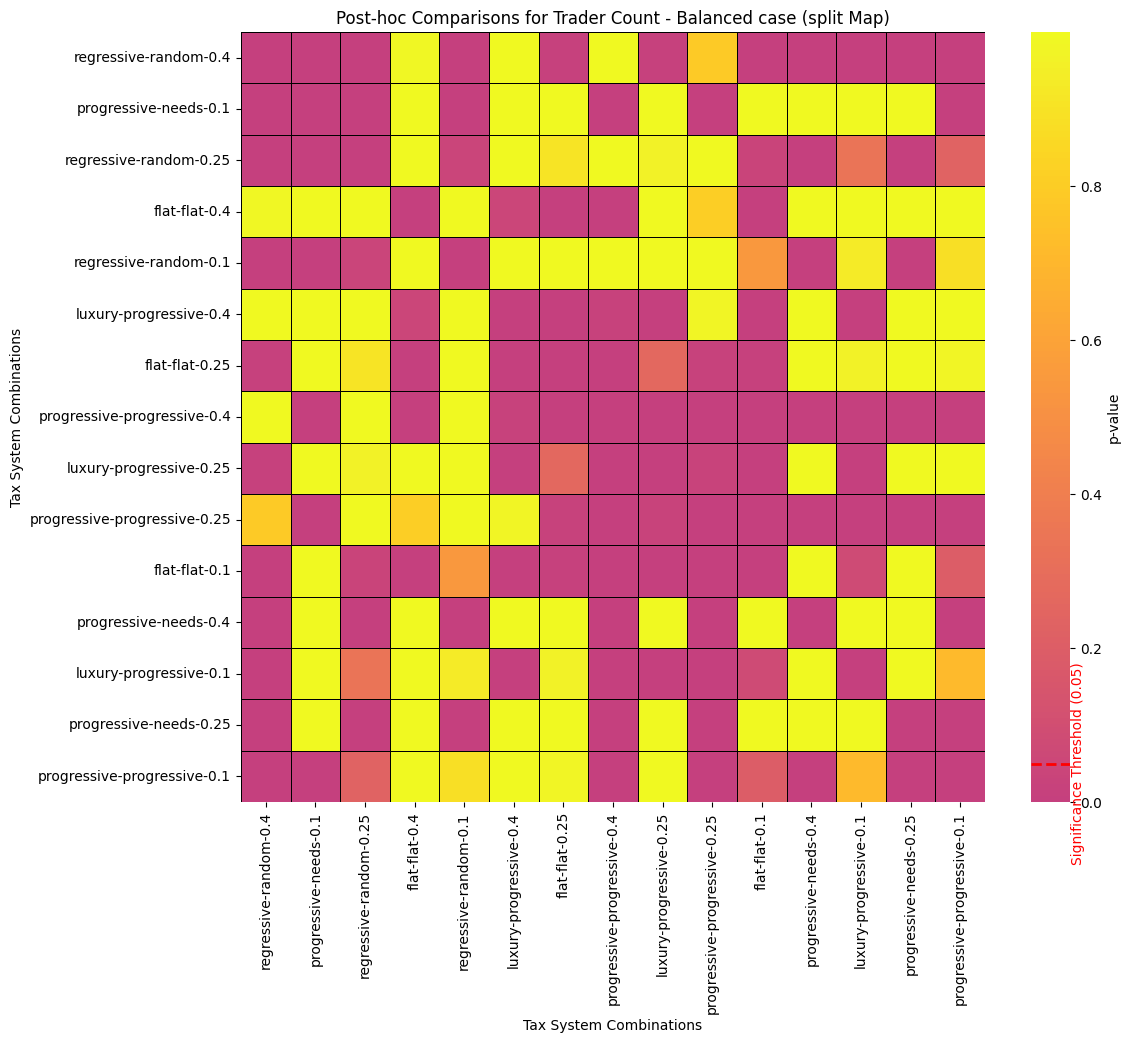

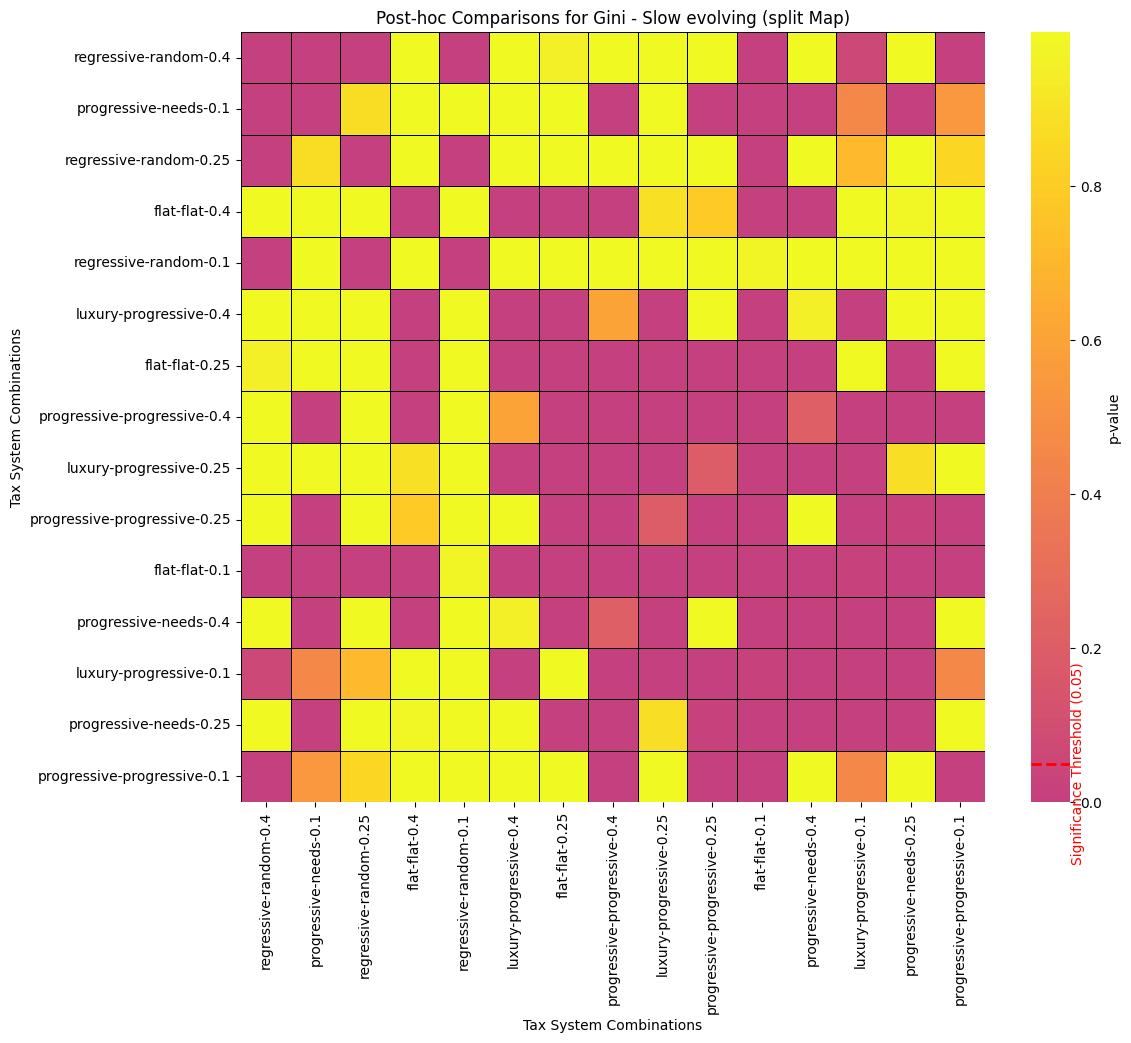

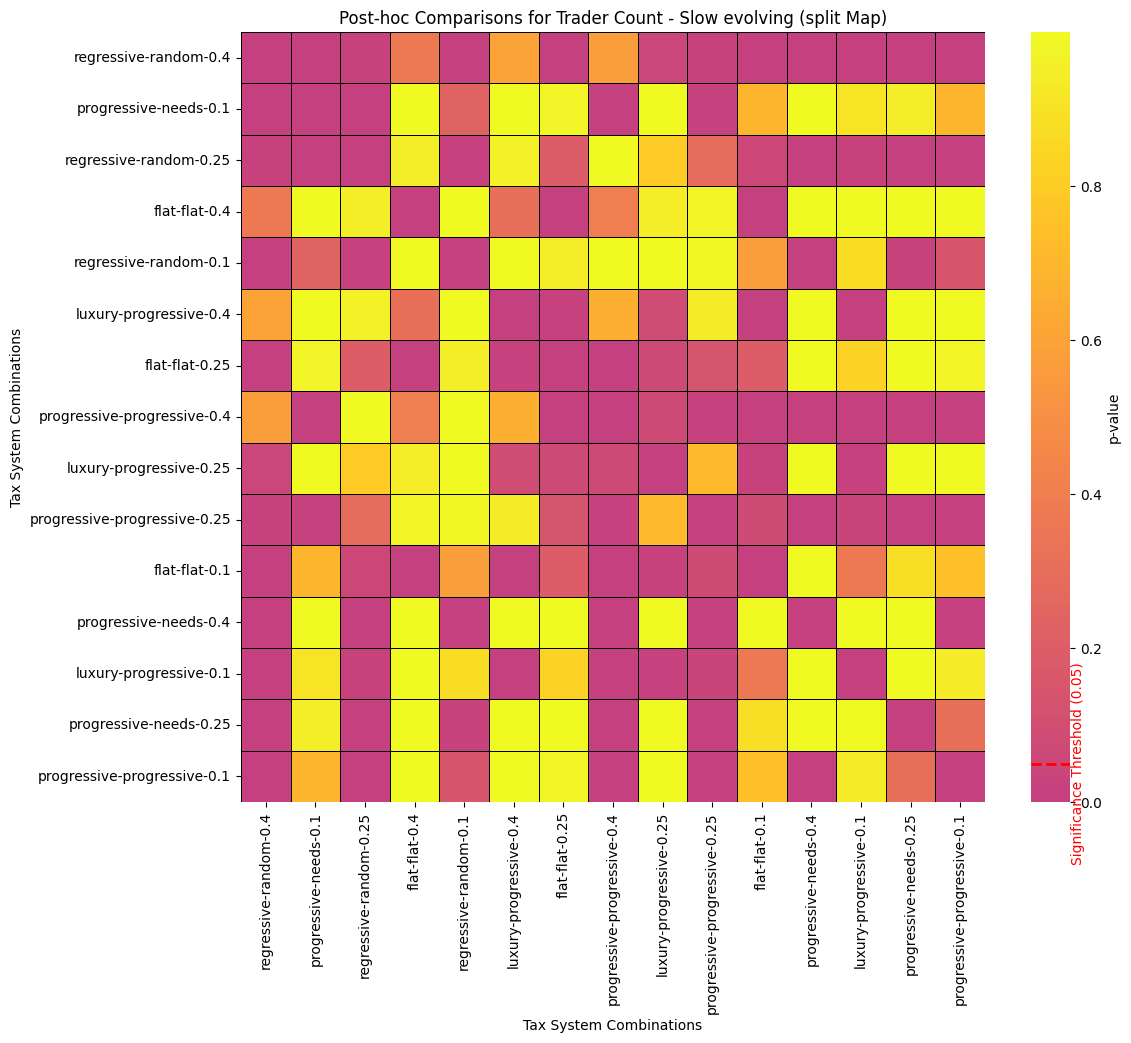

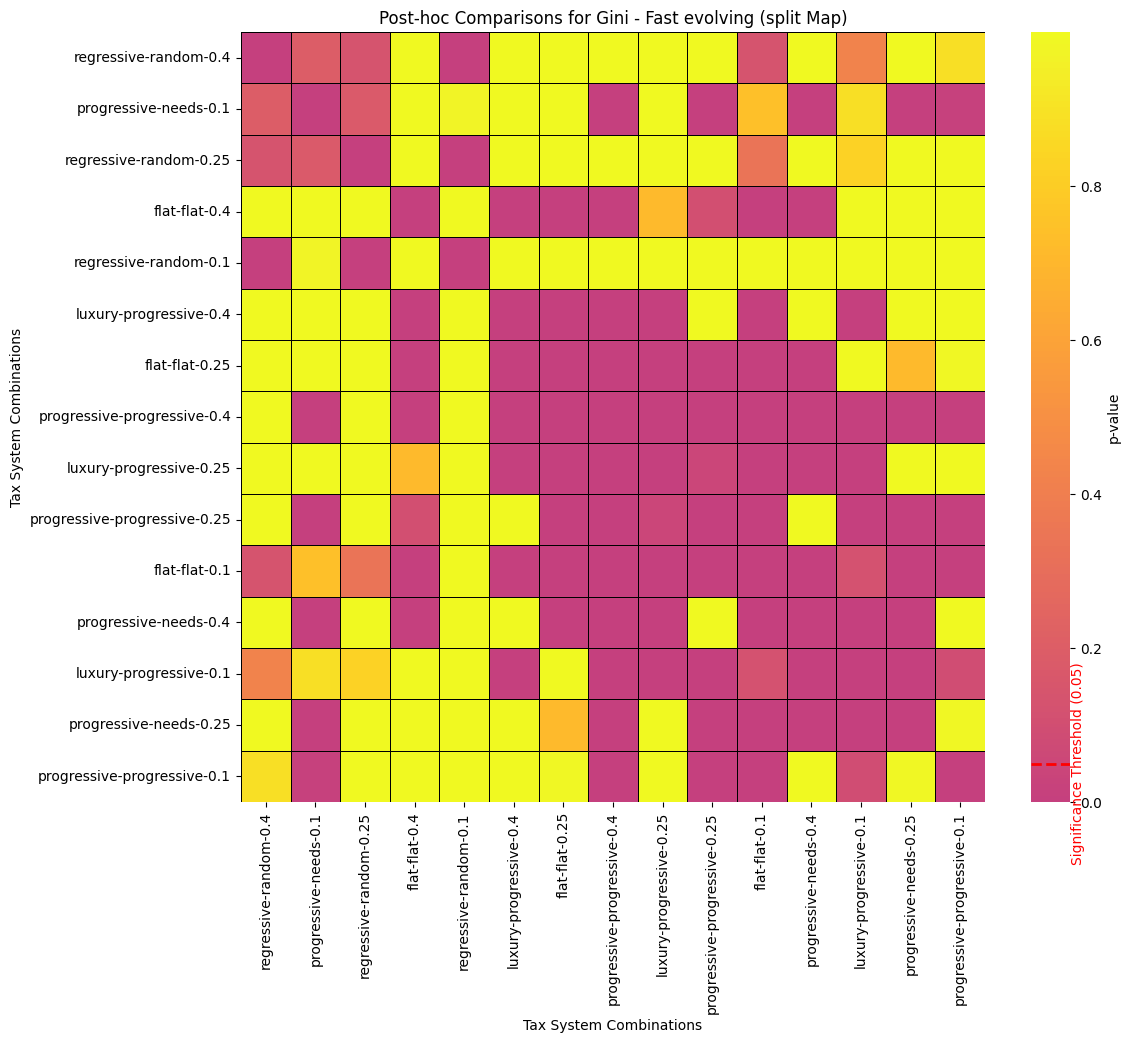

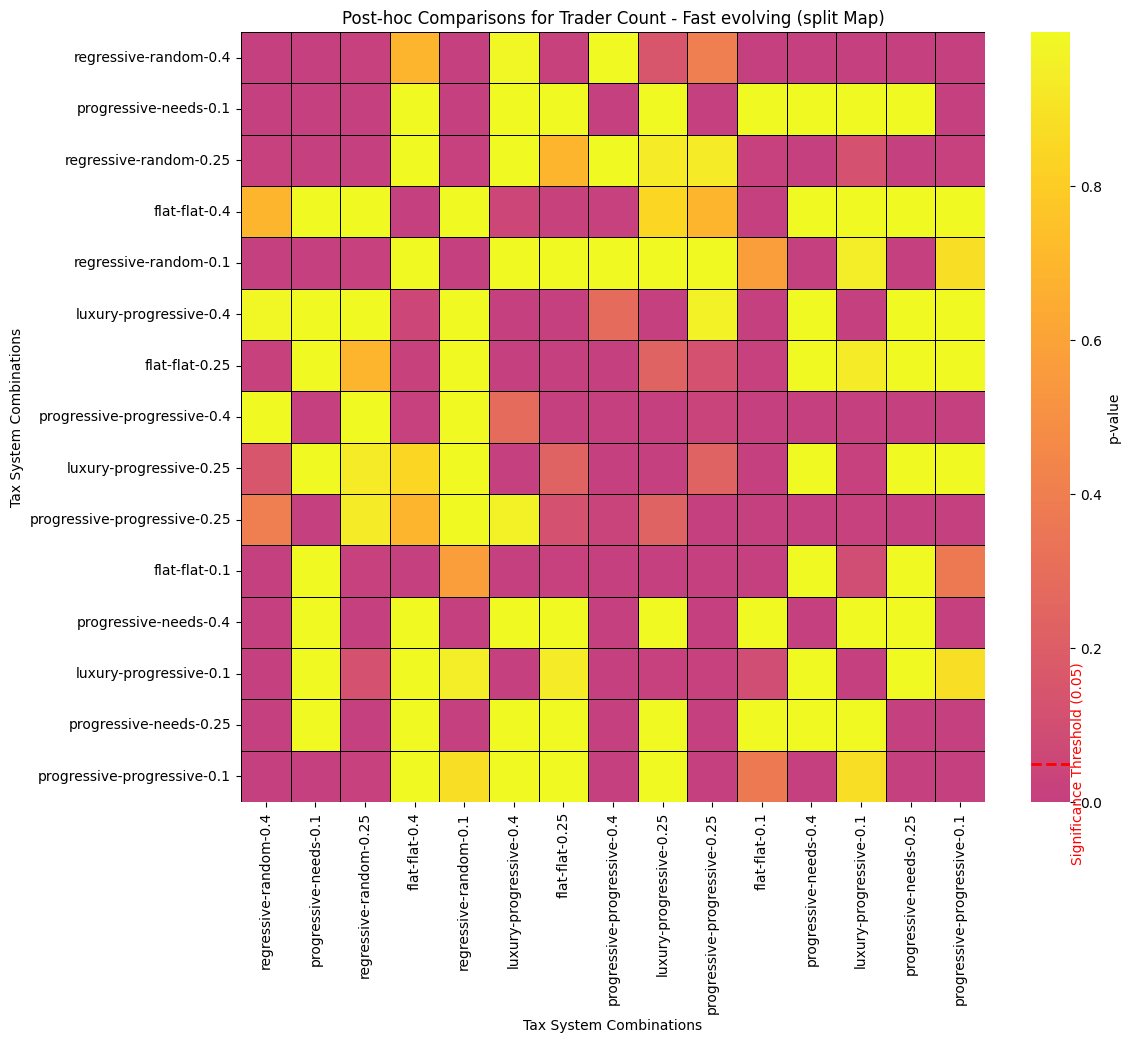


Final Tally of Best Combinations Across All Scenarios and Map Types:
Combination ('progressive', 'progressive', 0.4): Gini = 10, Trader Count = 5
Combination ('regressive', 'random', 0.4): Gini = 0, Trader Count = 3
Combination ('luxury', 'progressive', 0.4): Gini = 8, Trader Count = 5
Combination ('regressive', 'random', 0.25): Gini = 0, Trader Count = 2
Combination ('flat', 'flat', 0.4): Gini = 0, Trader Count = 1
Combination ('regressive', 'random', 0.1): Gini = 0, Trader Count = 1
Combination ('progressive', 'progressive', 0.25): Gini = 0, Trader Count = 1

Summary of Best Combinations:
Map Scheme | Scenario       | Metric       | Tax Scheme  | Distributor Scheme | Tax Rate | Mean Value | Rank
-----------------------------------------------------------------------------------------------------------
   uniform |    Worst case |         Gini | progressive |        progressive |      0.4 |       0.33 |  1.0
   uniform |    Worst case | Trader Count |  regressive |             random

In [6]:
# Initialize a tally dictionary to keep track of the best combinations
tally = {}

# Function to update tally
def update_tally(tally, combination, metric):
    """Update tally with the best combinations."""
    key = (combination['tax_scheme'], combination['distributer_scheme'], combination['tax_rate'])
    if key in tally:
        tally[key][metric] += 1
    else:
        tally[key] = {'Gini': 0, 'Trader Count': 0}
        tally[key][metric] = 1

# Function to print a summary table
def print_summary_table(combinations, title):
    """Print a summary table of the best combinations."""
    print(f"\nSummary of {title} Combinations:")
    print("Map Scheme | Scenario       | Metric       | Tax Scheme  | Distributor Scheme | Tax Rate | Mean Value | Rank")
    print("-----------------------------------------------------------------------------------------------------------")
    for entry in combinations:
        print(f"{entry['map_scheme']:>10} | {entry['scenario_name']:>13} | {entry['metric']:>12} | "
              f"{entry['tax_scheme']:>11} | {entry['distributer_scheme']:>18} | {entry['tax_rate']:>8} | "
              f"{entry['mean_value']:>10.2f} | {entry['rank']:>4}")

# Function to gather best and worst combinations for summary table
def gather_combinations(data, map_schemes, scenarios):
    """Gather the best and worst combinations for each map scheme and scenario."""
    best_combinations = []
    worst_combinations = []

    for map_scheme, scenario in itertools.product(map_schemes, scenarios):
        scenario_name = scenario['Scenario']
        map_data = data[data['map_scheme'] == map_scheme]
        
        # Filter posthoc results for the specific map scheme
        gini_posthoc_map = posthoc_comparisons(map_data, 'Gini', scenarios, alternative='less') if any(p < 0.05 for _, p in kruskal_test(map_data, 'Gini', scenarios).values()) else None
        trader_count_posthoc_map = posthoc_comparisons(map_data, 'Trader Count', scenarios, alternative='greater') if any(p < 0.05 for _, p in kruskal_test(map_data, 'Trader Count', scenarios).values()) else None
        
        plot_posthoc_heatmap(gini_posthoc_map, map_scheme, scenario_name, 'Gini')
        plot_posthoc_heatmap(trader_count_posthoc_map, map_scheme, scenario_name, 'Trader Count')
        
        # Rank combinations
        gini_ranks = rank_combinations(data, map_scheme, scenario_name, 'Gini')
        trader_count_ranks = rank_combinations(data, map_scheme, scenario_name, 'Trader Count')
        
        # Get best and worst combinations
        best_gini_combination = gini_ranks.loc[gini_ranks['Rank'].idxmin()]
        worst_gini_combination = gini_ranks.loc[gini_ranks['Rank'].idxmax()]
        
        best_trader_combination = trader_count_ranks.loc[trader_count_ranks['Rank'].idxmin()]
        worst_trader_combination = trader_count_ranks.loc[trader_count_ranks['Rank'].idxmax()]
        
        # Add to summary list
        best_combinations.append({
            'map_scheme': map_scheme,
            'scenario_name': scenario_name,
            'metric': 'Gini',
            'tax_scheme': best_gini_combination['tax_scheme'],
            'distributer_scheme': best_gini_combination['distributer_scheme'],
            'tax_rate': best_gini_combination['tax_rate'],
            'mean_value': best_gini_combination['Gini_mean'],
            'rank': best_gini_combination['Rank']
        })
        best_combinations.append({
            'map_scheme': map_scheme,
            'scenario_name': scenario_name,
            'metric': 'Trader Count',
            'tax_scheme': best_trader_combination['tax_scheme'],
            'distributer_scheme': best_trader_combination['distributer_scheme'],
            'tax_rate': best_trader_combination['tax_rate'],
            'mean_value': best_trader_combination['Trader Count_mean'],
            'rank': best_trader_combination['Rank']
        })

        worst_combinations.append({
            'map_scheme': map_scheme,
            'scenario_name': scenario_name,
            'metric': 'Gini',
            'tax_scheme': worst_gini_combination['tax_scheme'],
            'distributer_scheme': worst_gini_combination['distributer_scheme'],
            'tax_rate': worst_gini_combination['tax_rate'],
            'mean_value': worst_gini_combination['Gini_mean'],
            'rank': worst_gini_combination['Rank']
        })
        worst_combinations.append({
            'map_scheme': map_scheme,
            'scenario_name': scenario_name,
            'metric': 'Trader Count',
            'tax_scheme': worst_trader_combination['tax_scheme'],
            'distributer_scheme': worst_trader_combination['distributer_scheme'],
            'tax_rate': worst_trader_combination['tax_rate'],
            'mean_value': worst_trader_combination['Trader Count_mean'],
            'rank': worst_trader_combination['Rank']
        })

        # Update the tally
        update_tally(tally, best_gini_combination, 'Gini')
        update_tally(tally, best_trader_combination, 'Trader Count')
    
    return best_combinations, worst_combinations

# Define map schemes
map_schemes = ['uniform', 'top_heavy', 'split']

# Gather best and worst combinations
best_combinations, worst_combinations = gather_combinations(data, map_schemes, scenarios)

# Print the final tally
print("\nFinal Tally of Best Combinations Across All Scenarios and Map Types:")
for key, value in tally.items():
    print(f"Combination {key}: Gini = {value['Gini']}, Trader Count = {value['Trader Count']}")

# Print the summary tables
print_summary_table(best_combinations, "Best")
print_summary_table(worst_combinations, "Worst")


# Best Combinations Map

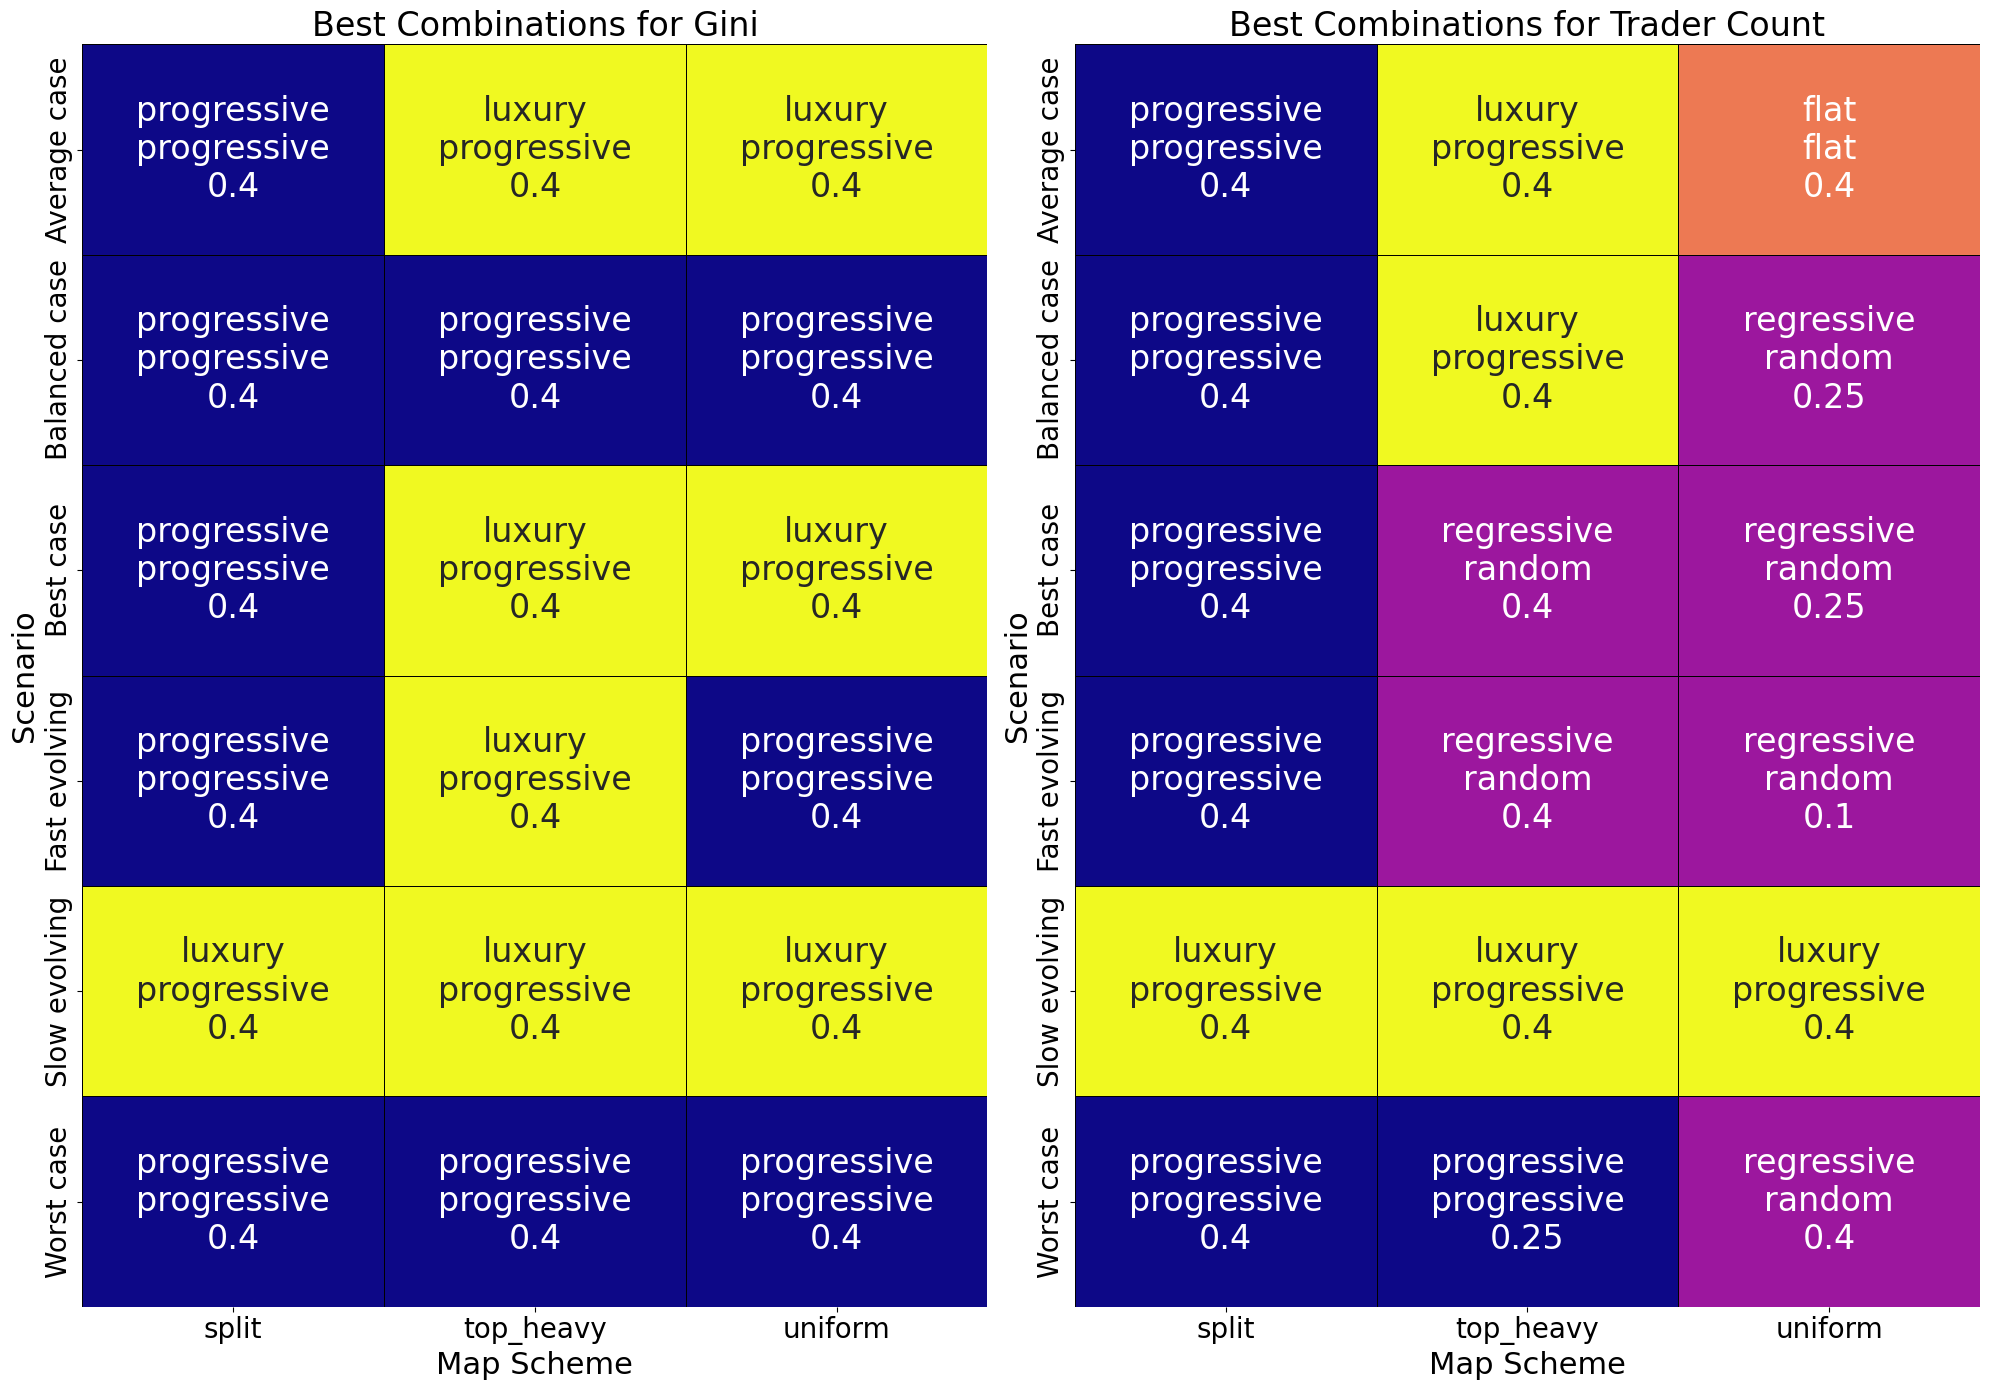

In [7]:
# Create DataFrames for each map scheme and metric
data_uniform_gini = pd.DataFrame({
    'Scenario': ['Worst case', 'Best case', 'Average case', 'Balanced case', 'Slow evolving', 'Fast evolving'],
    'Tax Scheme': ['progressive', 'luxury', 'luxury', 'progressive', 'luxury', 'progressive'],
    'Distributor Scheme': ['progressive', 'progressive', 'progressive', 'progressive', 'progressive', 'progressive'],
    'Tax Rate': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
})

data_uniform_trader = pd.DataFrame({
    'Scenario': ['Worst case', 'Best case', 'Average case', 'Balanced case', 'Slow evolving', 'Fast evolving'],
    'Tax Scheme': ['regressive', 'regressive', 'flat', 'regressive', 'luxury', 'regressive'],
    'Distributor Scheme': ['random', 'random', 'flat', 'random', 'progressive', 'random'],
    'Tax Rate': [0.4, 0.25, 0.4, 0.25, 0.4, 0.1]
})

data_top_heavy_gini = pd.DataFrame({
    'Scenario': ['Worst case', 'Best case', 'Average case', 'Balanced case', 'Slow evolving', 'Fast evolving'],
    'Tax Scheme': ['progressive', 'luxury', 'luxury', 'progressive', 'luxury', 'luxury'],
    'Distributor Scheme': ['progressive', 'progressive', 'progressive', 'progressive', 'progressive', 'progressive'],
    'Tax Rate': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
})

data_top_heavy_trader = pd.DataFrame({
    'Scenario': ['Worst case', 'Best case', 'Average case', 'Balanced case', 'Slow evolving', 'Fast evolving'],
    'Tax Scheme': ['progressive', 'regressive', 'luxury', 'luxury', 'luxury', 'regressive'],
    'Distributor Scheme': ['progressive', 'random', 'progressive', 'progressive', 'progressive', 'random'],
    'Tax Rate': [0.25, 0.4, 0.4, 0.4, 0.4, 0.4]
})

data_split_gini = pd.DataFrame({
    'Scenario': ['Worst case', 'Best case', 'Average case', 'Balanced case', 'Slow evolving', 'Fast evolving'],
    'Tax Scheme': ['progressive', 'progressive', 'progressive', 'progressive', 'luxury', 'progressive'],
    'Distributor Scheme': ['progressive', 'progressive', 'progressive', 'progressive', 'progressive', 'progressive'],
    'Tax Rate': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
})

data_split_trader = pd.DataFrame({
    'Scenario': ['Worst case', 'Best case', 'Average case', 'Balanced case', 'Slow evolving', 'Fast evolving'],
    'Tax Scheme': ['progressive', 'progressive', 'progressive', 'progressive', 'luxury', 'progressive'],
    'Distributor Scheme': ['progressive', 'progressive', 'progressive', 'progressive', 'progressive', 'progressive'],
    'Tax Rate': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
})

data_combined = pd.concat([
    data_uniform_gini.assign(Map_Scheme='uniform', Metric='Gini'),
    data_uniform_trader.assign(Map_Scheme='uniform', Metric='Trader Count'),
    data_top_heavy_gini.assign(Map_Scheme='top_heavy', Metric='Gini'),
    data_top_heavy_trader.assign(Map_Scheme='top_heavy', Metric='Trader Count'),
    data_split_gini.assign(Map_Scheme='split', Metric='Gini'),
    data_split_trader.assign(Map_Scheme='split', Metric='Trader Count')
])

tax_scheme_mapping = {
    'progressive': 1,
    'regressive': 2,
    'flat': 3,
    'luxury': 4
}
distributor_scheme_mapping = {
    'progressive': 1,
    'random': 2,
    'flat': 3,
    'needs': 4
}

data_combined['Tax Scheme Code'] = data_combined['Tax Scheme'].map(tax_scheme_mapping)
data_combined['Distributor Scheme Code'] = data_combined['Distributor Scheme'].map(distributor_scheme_mapping)
data_combined['Annotation'] = data_combined['Tax Scheme'] + "\n" + data_combined['Distributor Scheme'] + "\n" + data_combined['Tax Rate'].astype(str)

pivot_data_gini = data_combined[data_combined['Metric'] == 'Gini'].pivot_table(index='Scenario', columns='Map_Scheme', values='Tax Scheme Code', aggfunc='first')
annotations_gini = data_combined[data_combined['Metric'] == 'Gini'].pivot_table(index='Scenario', columns='Map_Scheme', values='Annotation', aggfunc='first')

pivot_data_trader = data_combined[data_combined['Metric'] == 'Trader Count'].pivot_table(index='Scenario', columns='Map_Scheme', values='Tax Scheme Code', aggfunc='first')
annotations_trader = data_combined[data_combined['Metric'] == 'Trader Count'].pivot_table(index='Scenario', columns='Map_Scheme', values='Annotation', aggfunc='first')

def annotate_heatmap(data, annotations, ax=None, **kwargs):
    if not ax:
        ax = plt.gca()
    sns.heatmap(data, ax=ax, annot=annotations, fmt='', cmap='plasma', cbar=False, linewidths=0.5, linecolor='black', annot_kws={"size": 24}, **kwargs)

plt.figure(figsize=(20, 14))

# Plot Gini heatmap
plt.subplot(1, 2, 1)
annotate_heatmap(pivot_data_gini, annotations_gini)
plt.title('Best Combinations for Gini', fontsize=24)
plt.xlabel('Map Scheme', fontsize=22)
plt.ylabel('Scenario', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Plot Trader Count heatmap
plt.subplot(1, 2, 2)
annotate_heatmap(pivot_data_trader, annotations_trader)
plt.title('Best Combinations for Trader Count', fontsize=24)
plt.xlabel('Map Scheme', fontsize=22)
plt.ylabel('Scenario', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()


# Worst Combinations Map

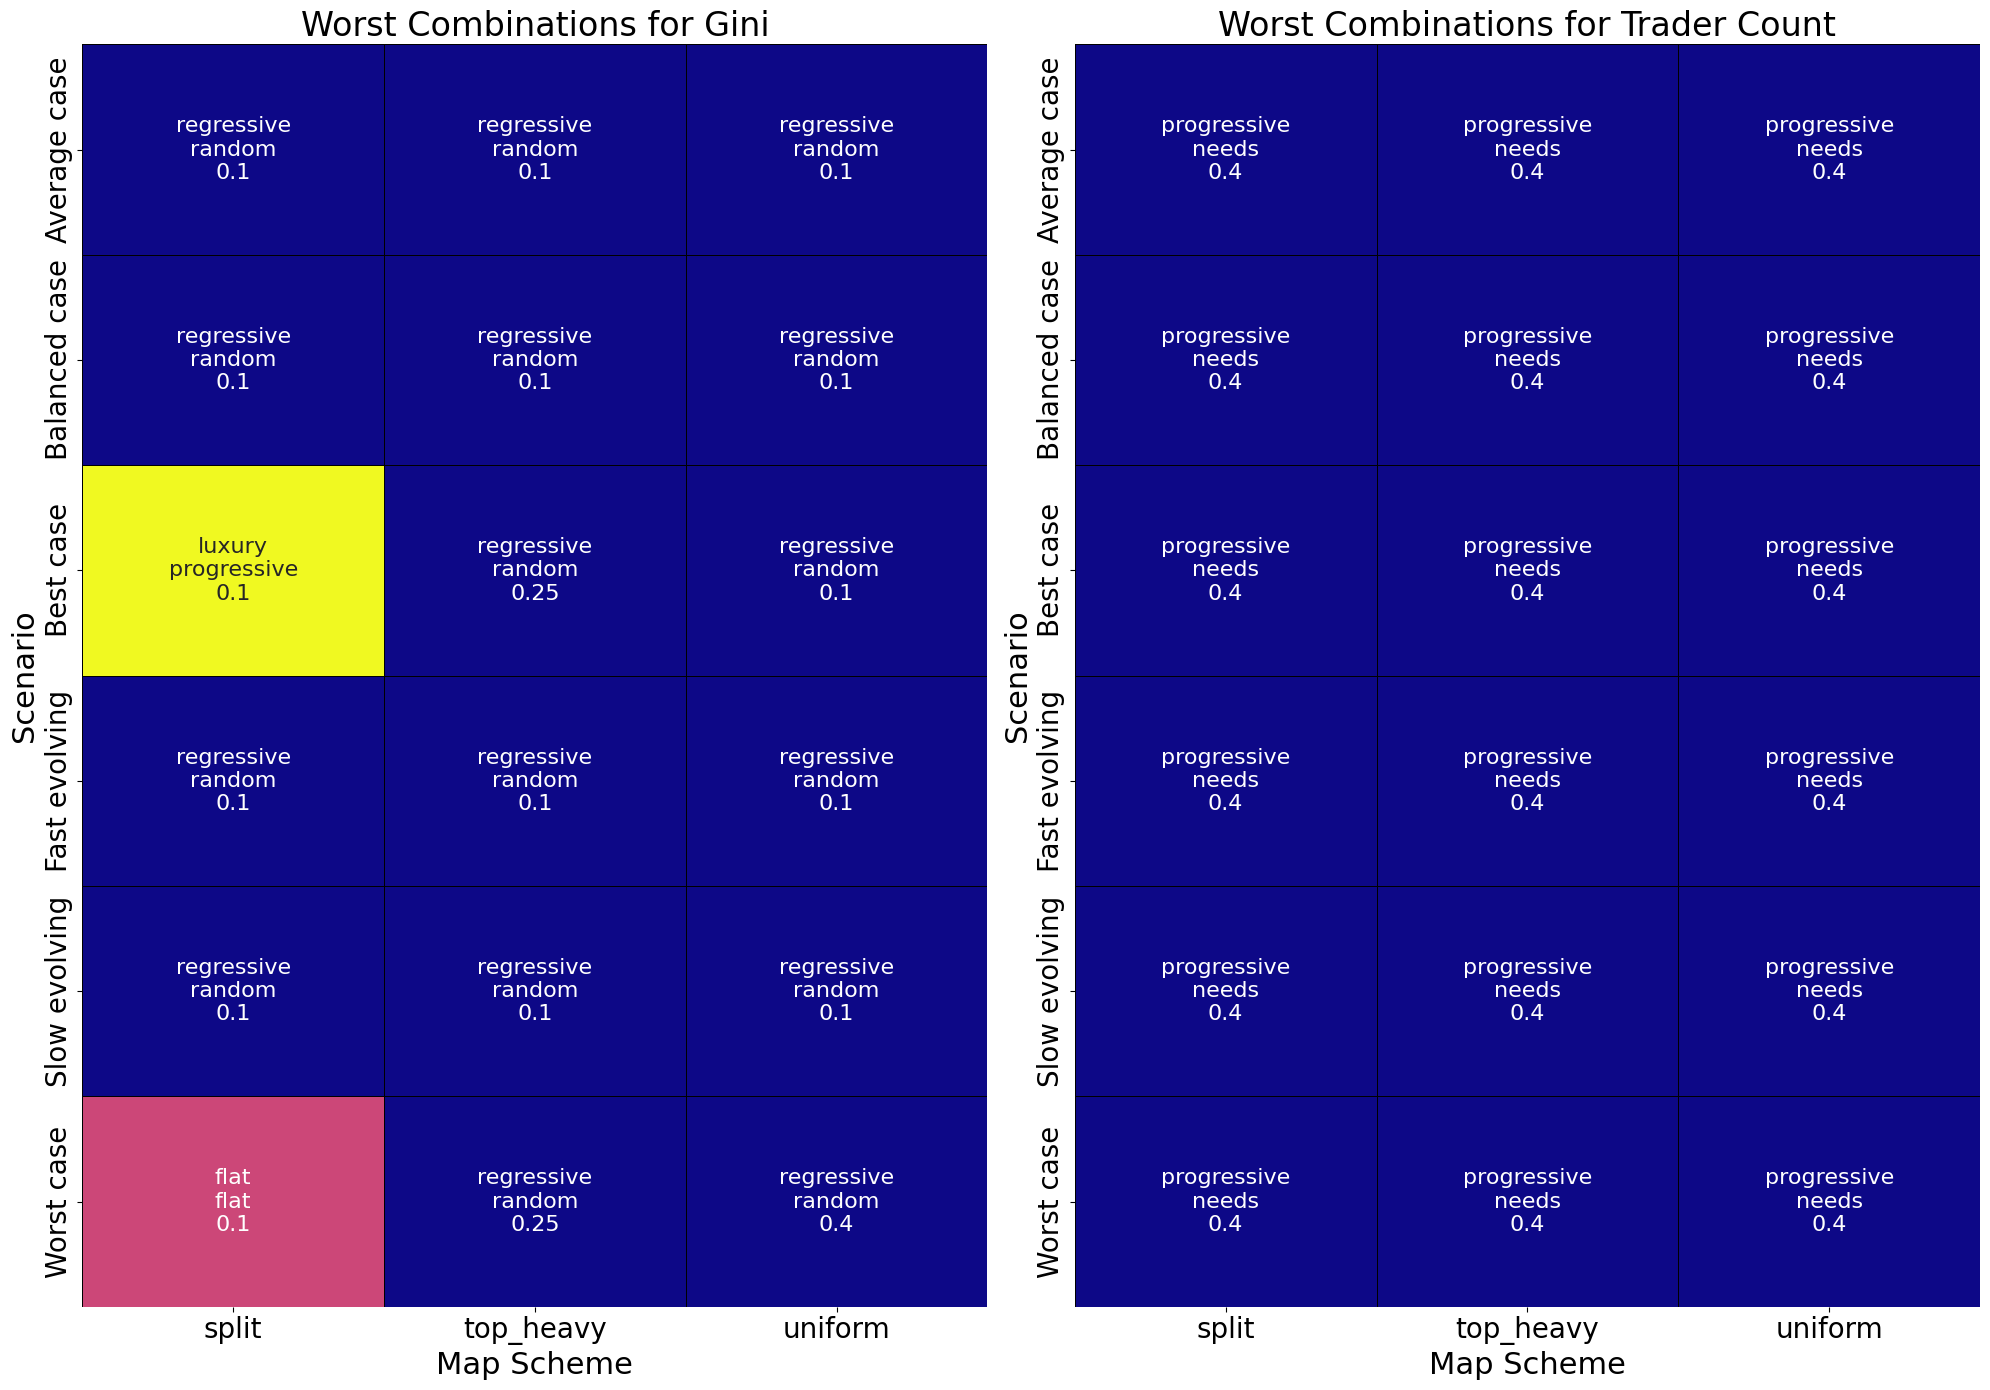

In [8]:
# Create DataFrames for each map scheme and metric for worst combinations
data_uniform_gini_worst = pd.DataFrame({
    'Scenario': ['Worst case', 'Best case', 'Average case', 'Balanced case', 'Slow evolving', 'Fast evolving'],
    'Tax Scheme': ['regressive', 'regressive', 'regressive', 'regressive', 'regressive', 'regressive'],
    'Distributor Scheme': ['random', 'random', 'random', 'random', 'random', 'random'],
    'Tax Rate': [0.4, 0.1, 0.1, 0.1, 0.1, 0.1]
})

data_uniform_trader_worst = pd.DataFrame({
    'Scenario': ['Worst case', 'Best case', 'Average case', 'Balanced case', 'Slow evolving', 'Fast evolving'],
    'Tax Scheme': ['progressive', 'progressive', 'progressive', 'progressive', 'progressive', 'progressive'],
    'Distributor Scheme': ['needs', 'needs', 'needs', 'needs', 'needs', 'needs'],
    'Tax Rate': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
})

data_top_heavy_gini_worst = pd.DataFrame({
    'Scenario': ['Worst case', 'Best case', 'Average case', 'Balanced case', 'Slow evolving', 'Fast evolving'],
    'Tax Scheme': ['regressive', 'regressive', 'regressive', 'regressive', 'regressive', 'regressive'],
    'Distributor Scheme': ['random', 'random', 'random', 'random', 'random', 'random'],
    'Tax Rate': [0.25, 0.25, 0.1, 0.1, 0.1, 0.1]
})

data_top_heavy_trader_worst = pd.DataFrame({
    'Scenario': ['Worst case', 'Best case', 'Average case', 'Balanced case', 'Slow evolving', 'Fast evolving'],
    'Tax Scheme': ['progressive', 'progressive', 'progressive', 'progressive', 'progressive', 'progressive'],
    'Distributor Scheme': ['needs', 'needs', 'needs', 'needs', 'needs', 'needs'],
    'Tax Rate': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
})

data_split_gini_worst = pd.DataFrame({
    'Scenario': ['Worst case', 'Best case', 'Average case', 'Balanced case', 'Slow evolving', 'Fast evolving'],
    'Tax Scheme': ['flat', 'luxury', 'regressive', 'regressive', 'regressive', 'regressive'],
    'Distributor Scheme': ['flat', 'progressive', 'random', 'random', 'random', 'random'],
    'Tax Rate': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
})

data_split_trader_worst = pd.DataFrame({
    'Scenario': ['Worst case', 'Best case', 'Average case', 'Balanced case', 'Slow evolving', 'Fast evolving'],
    'Tax Scheme': ['progressive', 'progressive', 'progressive', 'progressive', 'progressive', 'progressive'],
    'Distributor Scheme': ['needs', 'needs', 'needs', 'needs', 'needs', 'needs'],
    'Tax Rate': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
})

# Combine DataFrames
data_combined_worst = pd.concat([
    data_uniform_gini_worst.assign(Map_Scheme='uniform', Metric='Gini'),
    data_uniform_trader_worst.assign(Map_Scheme='uniform', Metric='Trader Count'),
    data_top_heavy_gini_worst.assign(Map_Scheme='top_heavy', Metric='Gini'),
    data_top_heavy_trader_worst.assign(Map_Scheme='top_heavy', Metric='Trader Count'),
    data_split_gini_worst.assign(Map_Scheme='split', Metric='Gini'),
    data_split_trader_worst.assign(Map_Scheme='split', Metric='Trader Count')
])

# Mapping for Tax Scheme and Distributor Scheme
tax_scheme_mapping = {
    'progressive': 1,
    'regressive': 2,
    'flat': 3,
    'luxury': 4
}
distributor_scheme_mapping = {
    'progressive': 1,
    'random': 2,
    'flat': 3,
    'needs': 4
}

data_combined_worst['Tax Scheme Code'] = data_combined_worst['Tax Scheme'].map(tax_scheme_mapping)
data_combined_worst['Distributor Scheme Code'] = data_combined_worst['Distributor Scheme'].map(distributor_scheme_mapping)
data_combined_worst['Annotation'] = data_combined_worst['Tax Scheme'] + "\n" + data_combined_worst['Distributor Scheme'] + "\n" + data_combined_worst['Tax Rate'].astype(str)

# Pivot data for heatmap
pivot_data_gini_worst = data_combined_worst[data_combined_worst['Metric'] == 'Gini'].pivot_table(index='Scenario', columns='Map_Scheme', values='Tax Scheme Code', aggfunc='first')
annotations_gini_worst = data_combined_worst[data_combined_worst['Metric'] == 'Gini'].pivot_table(index='Scenario', columns='Map_Scheme', values='Annotation', aggfunc='first')

pivot_data_trader_worst = data_combined_worst[data_combined_worst['Metric'] == 'Trader Count'].pivot_table(index='Scenario', columns='Map_Scheme', values='Tax Scheme Code', aggfunc='first')
annotations_trader_worst = data_combined_worst[data_combined_worst['Metric'] == 'Trader Count'].pivot_table(index='Scenario', columns='Map_Scheme', values='Annotation', aggfunc='first')

# Function to annotate heatmap
def annotate_heatmap(data, annotations, ax=None, **kwargs):
    if not ax:
        ax = plt.gca()
    sns.heatmap(data, ax=ax, annot=annotations, fmt='', cmap='plasma', cbar=False, linewidths=0.5, linecolor='black', annot_kws={"size": 16}, **kwargs)

# Plotting
plt.figure(figsize=(20, 14))

# Plot Gini heatmap
plt.subplot(1, 2, 1)
annotate_heatmap(pivot_data_gini_worst, annotations_gini_worst)
plt.title('Worst Combinations for Gini', fontsize=24)
plt.xlabel('Map Scheme', fontsize=22)
plt.ylabel('Scenario', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Plot Trader Count heatmap
plt.subplot(1, 2, 2)
annotate_heatmap(pivot_data_trader_worst, annotations_trader_worst)
plt.title('Worst Combinations for Trader Count', fontsize=24)
plt.xlabel('Map Scheme', fontsize=22)
plt.ylabel('Scenario', fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()
